# Machine Learning Projet : Stock Return Prediction

Axel PORTIER, Lucas STALTER, Gaspard SALLURON--BESNARD

# Project Overview

This project aims to predict the direction of residual stock returns in the U.S. market using historical financial data from Qube RT. The goal is to detect weak predictive signals rather than forecast exact prices, focusing on the underlying patterns that drive short-term stock movements once market effects are removed.

The dataset includes 46 numerical features, covering anonymized identifiers (`STOCK, INDUSTRY`, `SECTOR`) and 20-day histories of residual returns (`RET_1`–`RET_20`) and trading volumes (`VOLUME_1`–`VOLUME_20`). The target variable, `RET`, is binary, indicating whether the residual return at time t is positive or negative.

Following a structured machine learning pipeline, we perform data quality checks, feature preprocessing, and correlation analysis, then train both baseline models (e.g., Logistic Regression, Decision Trees) and advanced algorithms (e.g., Random Forest, XGBoost, Neural Networks). Model performance is assessed using F1-score and ROC-AUC, ensuring robust evaluation despite potential class imbalance.

Ultimately, this work explores how machine learning methods can capture meaningful financial patterns to support better decision-making in quantitative trading and risk management.

In [1]:
from pathlib import Path

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBClassifier

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from scipy.stats import skew, kurtosis
from sklearn.metrics import make_scorer
from sklearn.base import clone

from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier, RandomForestClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet, BayesianRidge

import math

# Phase I QUALITY CHECK & DATA EXPLORATION

The dataset consists of 46 descriptive features, all represented as numerical values (float or integer).

- `DATE` : an anonymized and randomized date index, without temporal continuity or sequential dependency.

- `STOCK` : an identifier representing the stock.

- `INDUSTRY`, `INDUSTRY_GROUP`, `SUB_INDUSTRY`, `SECTOR`: hierarchical categorical indices describing the economic domain of each stock (e.g., aeronautics, IT, oil, etc.).

- `RET_1` to `RET_20`: historical residual returns over the last 20 days, where `RET_1` corresponds to the previous day’s residual return, `RET_2` to two days before, and so on.

- `VOLUME_1` to `VOLUME_20`: historical relative trading volumes over the last 20 days, where `VOLUME_1` is the volume of the previous day.

The target variable, `RET`, is binary and represents the sign of the residual stock return at time t (i.e., positive or negative).

In the initial phase, the analysis focuses on understanding the dataset’s structure — specifically investigating missing values, class balance, and potential correlations among features.

### In the dataset we must acknowledge this : SUB INDUSTRY ⊂ INDUSTRY ⊂ INDUSTRY_GROUP ⊂ SECTOR 

## I) Data Loading & Initial Verification

In [103]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1) #axis = 1 concat by columns
test = pd.read_csv('./x_test.csv', index_col='ID')
ret_features = [f'RET_{day}' for day in range(1,21)]
vol_features = [f'VOLUME_{day}' for day in range(1,21)]
features = vol_features + ret_features
print(train.columns)
train.head()

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET'],
      dtype='object')


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


### Dataset features's types

In [576]:
train.info()
train.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

float64    40
int64       6
bool        1
Name: count, dtype: int64

### Type of the target

In [577]:
print(train['RET'].value_counts(normalize=True))
print(train['RET'].dtype)


RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64
bool


The target variable `RET` is well balanced, with approximately 50.1% False and 49.9% True values, indicating no significant class imbalance in the dataset. However, to experiment with different approaches, we will still address the imbalance problem later in the project.

### Dataset's dimensions :

In [578]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()
train.describe(include='all')

Train shape: (418595, 47)
Test shape: (198429, 46)


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000,418595
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209749
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337,NaN
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928,NaN
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790,NaN
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405,NaN
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795,NaN


# II) Data Processing

### From now on, we are gonna work on the train by the intermediary of the ***cleaning_train*** dataset in order to clearly seperate both

For simplicity and computational efficiency in testing and throughout the rest of the project, we will focus on **the last 10 days** of returns and volumes.

In [579]:
# to_drop = [f'RET_{day}' for day in range(11,21)]
# to_drop += [f'VOLUME_{day}' for day in range(11,21)]
# cleaning_train = train.drop(columns= to_drop).copy()
cleaning_train = train.copy()

## II.1) Missing values analysis

### 1-A) MISSING VALUES FOR TRAIN

#### Missing values distribution for train

In [580]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET_6              0.620409
VOLUME_6          17.848756
RET_7              0.617542
VOLUME_7          17.643068
RET_8              0.626620
VOLUME_8          17.653818
RET_9              0.640715
VOLUME_9          17.510481
RET_10             0.643104
VOLUME_10         17.512154
RET_11             0.707366
VOLUME_11         17.206369
RET_12             0.761118
VOLUME_12         14.936394
RET_13             0.802685
VOLUME_13         14.096681
RET_14             1.054241
VOLUME_14         14.555597
RET_15             1.192083
VOLUME_15         15

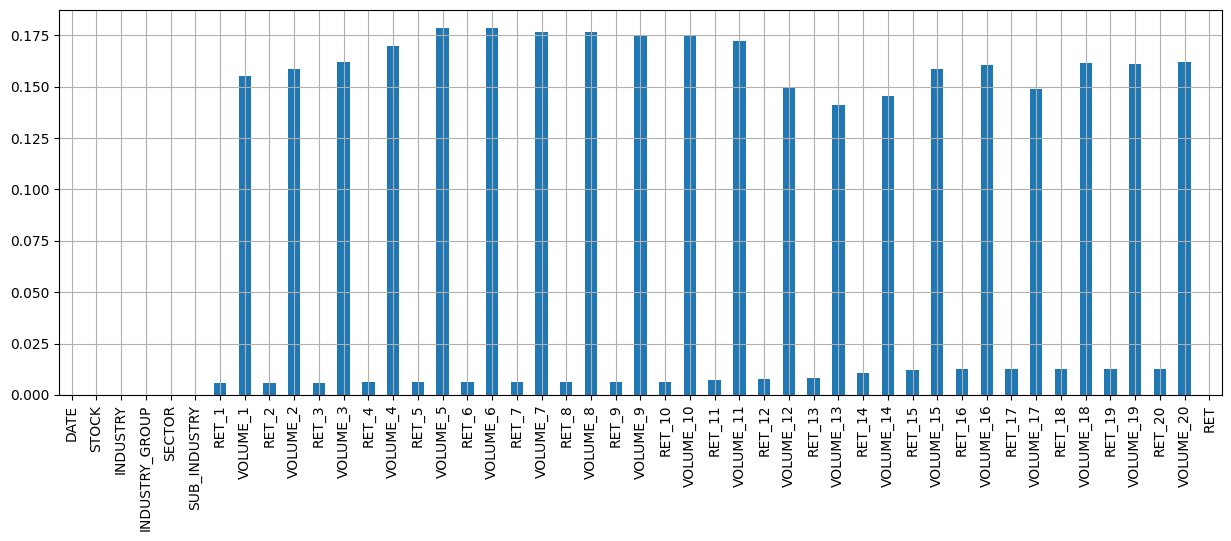

In [581]:
nb_missing = cleaning_train.isna().sum()
rate_missing = nb_missing / cleaning_train.index.nunique()

fig, ax = plt.subplots(figsize=(15,5))
rate_missing.plot(kind="bar", ax=ax)

ax.grid()
plt.xticks(rotation=90)
plt.show()


Most of the missing values are concentrated in the `VOLUME_1`..., with around **15% missing data**, which represents a considerable proportion. 
Consequently, a specific step will be devoted later to addressing these missing values.
It is also import to hightlight that there is no missing values in the `SECTOR` etc.

#### Percentage of missing values for each unique value within  `INDUSTRY`, `INDUSTRY_GROUP`, `SECTOR`, `SUB_INDUSTRY`, `STOCK`, and `DATE`.

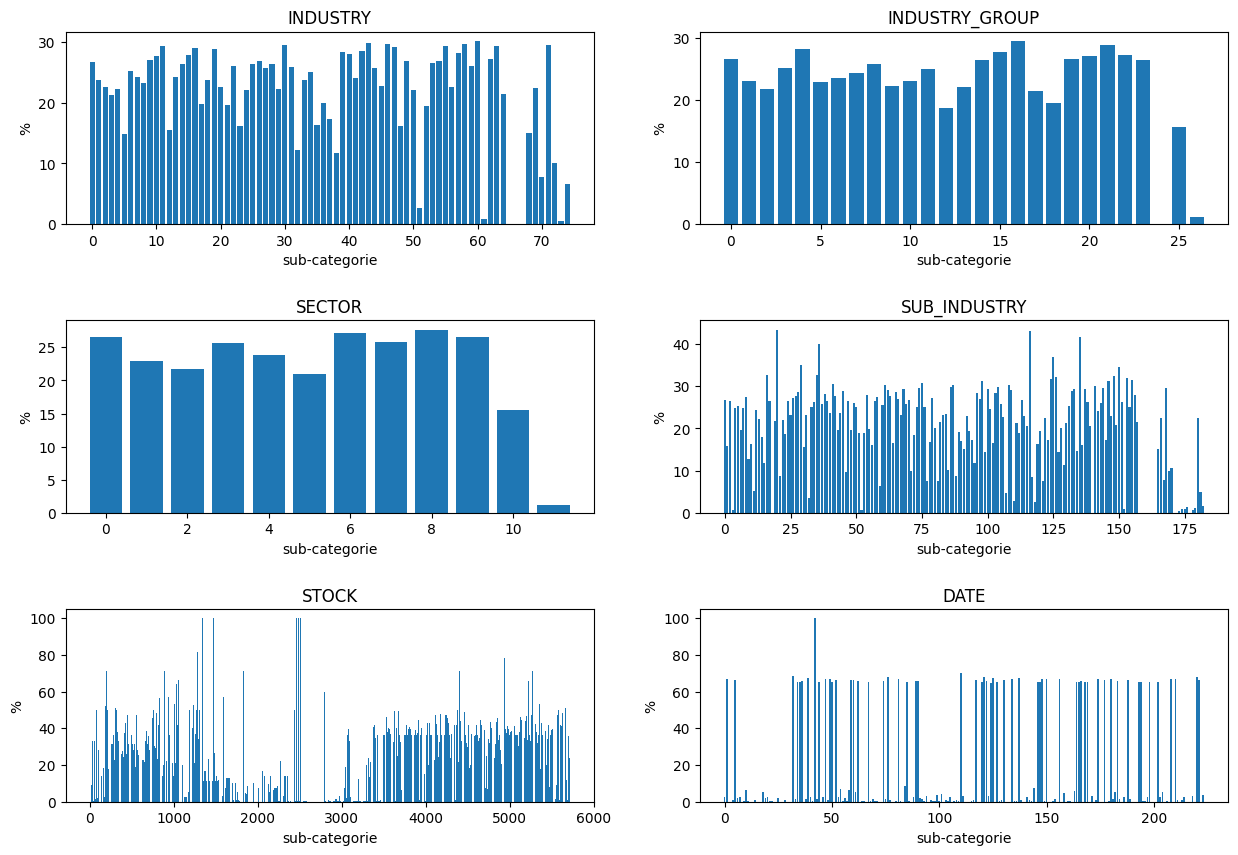

In [582]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    X_absciss = cleaning_train[categorie].sort_values().unique()

    unique_Y_values = cleaning_train[categorie].sort_values().unique()
    Y_absciss = [(cleaning_train[cleaning_train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(cleaning_train[cleaning_train[categorie]==sub_categorie])*100 for sub_categorie in unique_Y_values]
    
    plt.bar(X_absciss,Y_absciss)
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()

The plots display the percentage of NaN values per subcategory. We observe a relatively even distribution of missing values for the categorical variable SECTOR, whereas the amount of missing data in other categorical features appears less uniform.

It may be useful to investigate whether some rows mainly consist of missing values in the descriptive variables (RET and VOLUME). If that is the case, those observations can reasonably be removed, as they do not contribute meaningful information to the model.

We will first **remove rows with heavy missingness**, then **impute minor gaps** with consistent values.

#### Let's remove the rows where half or more of their features `RET_` and `VOL_` are NaN

In [583]:
to_drop = cleaning_train[cleaning_train[features].isna().sum(axis=1) >= len(features)*0.5][features].index
nb_drop = len(to_drop)
nb_rows = len(cleaning_train)
print(
    f"Number of rows before removing: {nb_rows}\n"
    f"Number of rows removed: {nb_drop}\n"
    f"Overall ratio (% of rows removed): {nb_drop / nb_rows * 100:.4f}%"
)


cleaning_train.drop(index = to_drop, axis=0, inplace = True)

Number of rows before removing: 418595
Number of rows removed: 12767
Overall ratio (% of rows removed): 3.0500%


About 13% of the rows were less than half complete, which is a significant proportion and an important aspect to take into account during data cleaning.

In [584]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.003450
VOLUME_1          12.925180
RET_2              0.005914
VOLUME_2          13.247731
RET_3              0.004435
VOLUME_3          13.598865
RET_4              0.002711
VOLUME_4          14.372099
RET_5              0.002711
VOLUME_5          15.279626
RET_6              0.004189
VOLUME_6          15.282336
RET_7              0.003203
VOLUME_7          15.068945
RET_8              0.002218
VOLUME_8          15.078309
RET_9              0.003203
VOLUME_9          14.928738
RET_10             0.002957
VOLUME_10         14.930463
RET_11             0.001478
VOLUME_11         14.601999
RET_12             0.034744
VOLUME_12         12.263323
RET_13             0.048050
VOLUME_13         11.395222
RET_14             0.230640
VOLUME_14         11.867836
RET_15             0.256266
VOLUME_15         13

From now on the stat of missing values are lower, but let's keep digging that way by replacing the missing values

#### Before that let's have a look at the features distributions

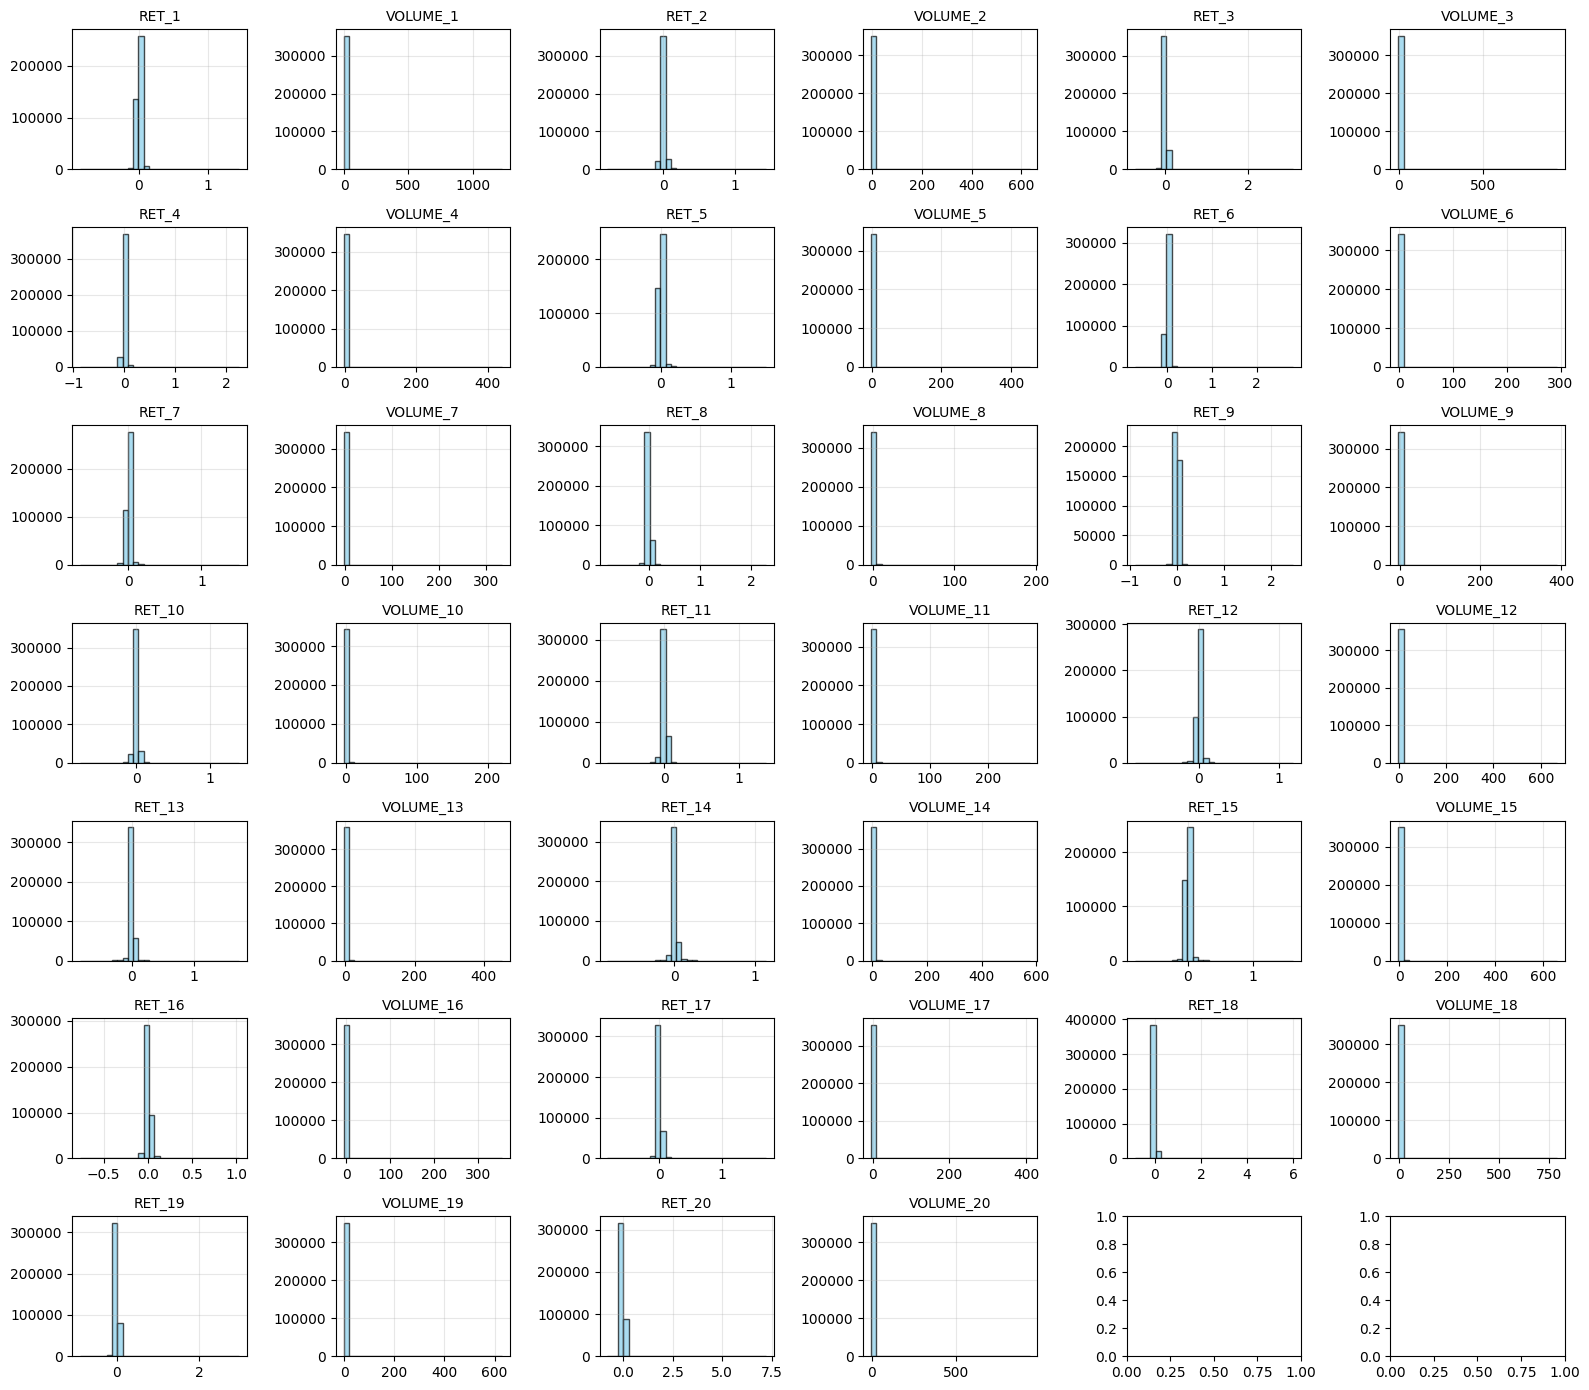

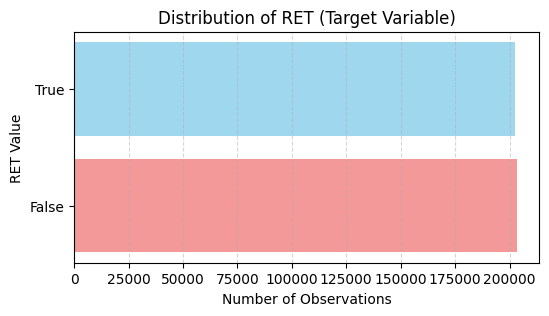

In [585]:
features = [col for col in cleaning_train.columns if col not in ["INDUSTRY", "INDUSTRY_GROUP", "SECTOR", "SUB_INDUSTRY", "STOCK", "DATE","RET"]]
n_cols = 6
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    cleaning_train[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(feature, fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

ret_counts = cleaning_train["RET"].value_counts()
plt.figure(figsize=(6, 3))
plt.barh(ret_counts.index.astype(str), ret_counts.values, color=["lightcoral", "skyblue"], alpha=0.8)
plt.title("Distribution of RET (Target Variable)")
plt.xlabel("Number of Observations")
plt.ylabel("RET Value")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


The plots are not very meaningful since most values are centered around 0. This is consistent with the nature of the data: we are dealing with relative volumes and residual returns, which are either normalized or expressed relative to market behavior after removing overall market effects. Nevertheless, it is interesting to note that the RET values are fairly well balanced.

In [586]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,11):
    volume.loc[day] =[day, cleaning_train[f'RET_{day}'].mean(), cleaning_train[f'RET_{day}'].median(), cleaning_train[f'RET_{day}'].std(), 
                      cleaning_train[f'VOLUME_{day}'].mean(), cleaning_train[f'VOLUME_{day}'].median(), cleaning_train[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001428,0.000691,0.031144,-0.071951,-0.282598,3.029095
2,2.0,0.001065,0.000518,0.030788,-0.075310,-0.278445,2.635940
3,3.0,0.002127,0.000953,0.031118,-0.097339,-0.278301,2.491170
4,4.0,-0.000793,-0.000595,0.030868,-0.089270,-0.275468,1.729502
5,5.0,0.000335,-0.000207,0.031644,-0.092331,-0.281258,1.848408
6,6.0,-0.000343,0.000000,0.031083,-0.100523,-0.288132,1.689204
7,7.0,0.000363,0.000168,0.030751,-0.084742,-0.284767,1.839759
8,8.0,0.000148,-0.000137,0.031326,-0.087015,-0.289754,1.595849
9,9.0,-0.000679,-0.000211,0.032676,-0.090916,-0.298195,1.857260
10,10.0,0.000115,0.000000,0.031323,-0.092331,-0.295769,1.652158


#### Missing Value Imputation Choice for `VOL_`

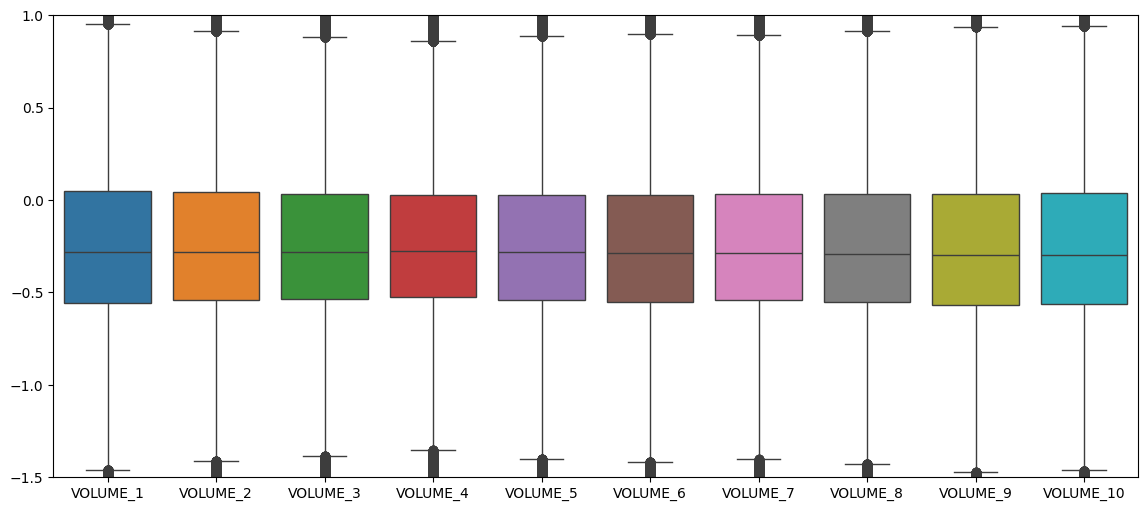

In [587]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'VOLUME_{day}' for day in range(1,11)]])
plt.ylim((-1.5,1))
plt.show()

##### Justification for Missing-Value Imputation (Volumes)

**A quick reminder — what is skewness?**  
Skewness describes the *asymmetry* of a distribution:  
- **Symmetric**: left and right tails are similar; mean ≈ median.  
- **Left-skewed (negative skew)**: longer/larger tail on the left; **mean < median**.  
- **Right-skewed (positive skew)**: longer/larger tail on the right; **mean > median**.  

**What we observe for `VOLUME_1`–`VOLUME_10`:**  
- The **median is around −0.25** across all volume features (i.e., slightly shifted left, not centered at 0, and showing **no extreme skew**).  
- Outliers exist but are not dominant, and we will handle them later.  

**Why we impute with the median:**  
- The **median is robust** to outliers, unlike the mean, which is affected by them.  
- Therefore, based on our boxplots, imputing with the **mean** would be too optimistic and could distort the true distribution.



In [588]:
per_feature_median_volume = cleaning_train[vol_features].median()
print(per_feature_median_volume)
cleaning_train[vol_features] = cleaning_train[vol_features].fillna(per_feature_median_volume)

VOLUME_1    -0.282598
VOLUME_2    -0.278445
VOLUME_3    -0.278301
VOLUME_4    -0.275468
VOLUME_5    -0.281258
VOLUME_6    -0.288132
VOLUME_7    -0.284767
VOLUME_8    -0.289754
VOLUME_9    -0.298195
VOLUME_10   -0.295769
VOLUME_11   -0.291194
VOLUME_12   -0.291345
VOLUME_13   -0.292227
VOLUME_14   -0.293027
VOLUME_15   -0.282044
VOLUME_16   -0.272271
VOLUME_17   -0.285476
VOLUME_18   -0.281744
VOLUME_19   -0.277668
VOLUME_20   -0.283404
dtype: float64


#### Missing Value Imputation Choice for `RET_`

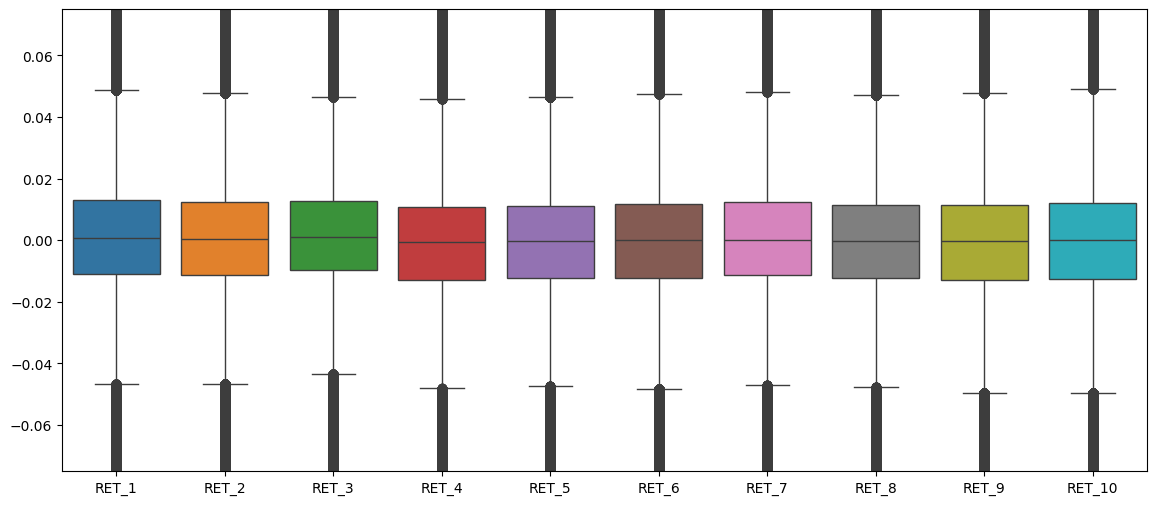

In [589]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'RET_{day}' for day in range(1,11)]])
plt.ylim((-0.075,0.075))
plt.show()

For the `RET_` features, the **median is close to 0**, indicating a symmetric distribution around the center.  
Although imputing missing values with the **mean** could be appropriate in this case, we will use the **median** instead to remain consistent with a **robust imputation strategy** less sensitive to potential outliers.


In [590]:
per_feature_median_return  = cleaning_train[ret_features].median()
print(per_feature_median_return)
cleaning_train[ret_features] = cleaning_train[ret_features].fillna(per_feature_median_return)

RET_1     0.000691
RET_2     0.000518
RET_3     0.000953
RET_4    -0.000595
RET_5    -0.000207
RET_6     0.000000
RET_7     0.000168
RET_8    -0.000137
RET_9    -0.000211
RET_10    0.000000
RET_11   -0.000579
RET_12    0.000000
RET_13    0.001094
RET_14    0.001144
RET_15    0.000814
RET_16    0.000509
RET_17    0.000413
RET_18    0.000000
RET_19    0.000000
RET_20    0.000000
dtype: float64


#### Just checking that all the features are well imputated

In [591]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE              0.0
STOCK             0.0
INDUSTRY          0.0
INDUSTRY_GROUP    0.0
SECTOR            0.0
SUB_INDUSTRY      0.0
RET_1             0.0
VOLUME_1          0.0
RET_2             0.0
VOLUME_2          0.0
RET_3             0.0
VOLUME_3          0.0
RET_4             0.0
VOLUME_4          0.0
RET_5             0.0
VOLUME_5          0.0
RET_6             0.0
VOLUME_6          0.0
RET_7             0.0
VOLUME_7          0.0
RET_8             0.0
VOLUME_8          0.0
RET_9             0.0
VOLUME_9          0.0
RET_10            0.0
VOLUME_10         0.0
RET_11            0.0
VOLUME_11         0.0
RET_12            0.0
VOLUME_12         0.0
RET_13            0.0
VOLUME_13         0.0
RET_14            0.0
VOLUME_14         0.0
RET_15            0.0
VOLUME_15         0.0
RET_16            0.0
VOLUME_16         0.0
RET_17            0.0
VOLUME_17         0.0
RET_18            0.0
VOLUME_18         0.0
RET_19            0.0
VOLUME_19         0.0
RET_20            0.0
VOLUME_20 

Alright, the missing values have been successfully replaced using the median strategy.  
We can now move on to the **outlierss**, where we will different methods in order to remove them.


### 1-B) MISSING VALUES FOR TEST 

In [592]:
test.isna().sum(axis = 0)/len(test)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.004032
VOLUME_1          13.702634
RET_2              0.008567
VOLUME_2          12.797525
RET_3              0.011087
VOLUME_3          13.793851
RET_4              0.016631
VOLUME_4          14.715087
RET_5              0.021166
VOLUME_5          15.670593
RET_6              0.022678
VOLUME_6          15.674120
RET_7              0.023182
VOLUME_7          15.677648
RET_8              0.022174
VOLUME_8          15.683191
RET_9              0.020158
VOLUME_9          15.687223
RET_10             0.030238
VOLUME_10         14.742301
RET_11             0.530668
VOLUME_11         14.254469
RET_12             0.083657
VOLUME_12         12.780390
RET_13             0.138085
VOLUME_13         12.843889
RET_14             0.837579
VOLUME_14         14.419767
RET_15             1.017492
VOLUME_15         14

We've identified missing values in the test dataset. To ensure consistent preprocessing and prevent data leakage, we'll impute these values using the same strategy applied to the training set.

Specifically, missing values will be replaced by the median of their respective columns, which was **pre-calculated** on the training data. This approach ensures the test set imputation introduces no information from the test set itself.

In [593]:
test[vol_features] = test[vol_features].fillna(per_feature_median_volume)

test[ret_features] = test[ret_features].fillna(per_feature_median_return)

In [594]:
test.isna().sum(axis = 0)/len(test)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE              0.0
STOCK             0.0
INDUSTRY          0.0
INDUSTRY_GROUP    0.0
SECTOR            0.0
SUB_INDUSTRY      0.0
RET_1             0.0
VOLUME_1          0.0
RET_2             0.0
VOLUME_2          0.0
RET_3             0.0
VOLUME_3          0.0
RET_4             0.0
VOLUME_4          0.0
RET_5             0.0
VOLUME_5          0.0
RET_6             0.0
VOLUME_6          0.0
RET_7             0.0
VOLUME_7          0.0
RET_8             0.0
VOLUME_8          0.0
RET_9             0.0
VOLUME_9          0.0
RET_10            0.0
VOLUME_10         0.0
RET_11            0.0
VOLUME_11         0.0
RET_12            0.0
VOLUME_12         0.0
RET_13            0.0
VOLUME_13         0.0
RET_14            0.0
VOLUME_14         0.0
RET_15            0.0
VOLUME_15         0.0
RET_16            0.0
VOLUME_16         0.0
RET_17            0.0
VOLUME_17         0.0
RET_18            0.0
VOLUME_18         0.0
RET_19            0.0
VOLUME_19         0.0
RET_20            0.0
VOLUME_20 

## II.2) Outliers handling

### IQR Method

Nb lignes supprimées IQR : 209841, equivalently to 51.7% of total dataset


(-0.05, 0.05)

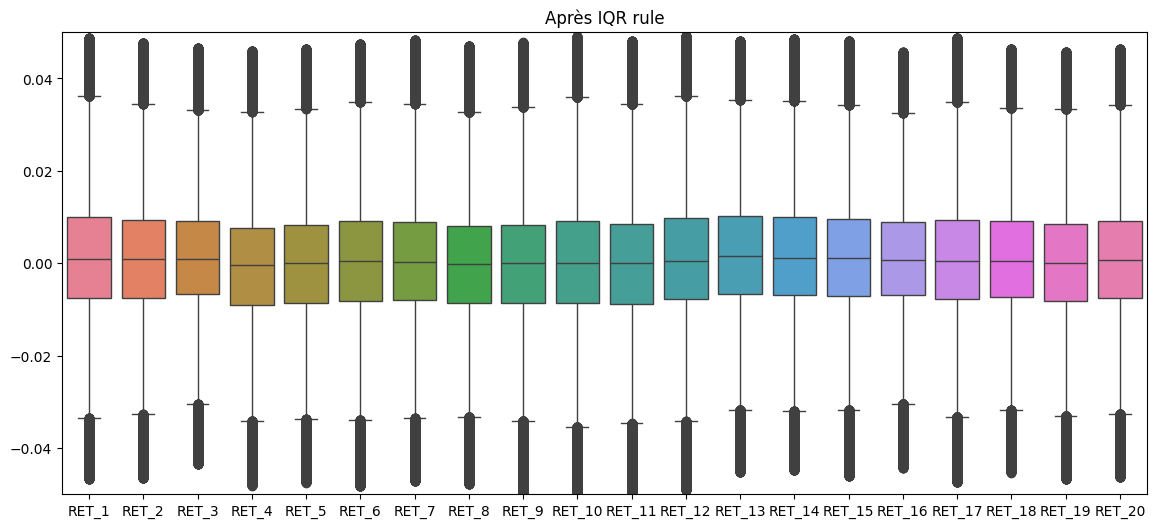

In [595]:
features = ret_features + vol_features
X = cleaning_train[ret_features]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
cleaning_train_iqr = cleaning_train[mask_iqr]

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iqr)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")
plt.figure(figsize=(14, 6))
sns.boxplot(cleaning_train_iqr[ret_features])
plt.title("Après IQR rule")
plt.ylim((-0.05, 0.05))

The **Interquartile Range (IQR) rule** was applied to detect and remove outliers in the `RET_` features.  

$$
\text{Lower bound} = Q1 - 1.5 \times IQR
$$
$$
\text{Upper bound} = Q3 + 1.5 \times IQR
$$

$$ IQR = Q3 - Q1 $$

This method identifies values lying beyond **1.5 × IQR** from the first (Q1) and third (Q3) quartiles.  
After applying this rule, the overall distribution of returns remains consistent, with medians close to 0 and fewer extreme values.  
This confirms that the 37% removed observations were genuine outliers, allowing for a **cleaner and more stable dataset** while preserving the main statistical structure.

### IsolationForest Method

Nb lignes supprimées IQR : 20292, equivalently to 5.0% of total dataset


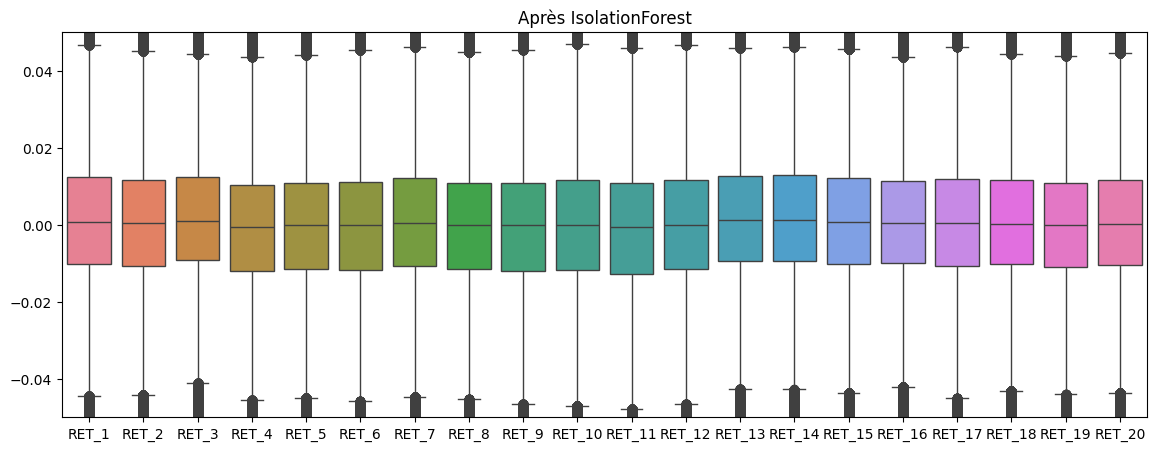

In [596]:
# --- Méthode 2 : IsolationForest ---
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso.fit_predict(X)
cleaning_train_iso = cleaning_train[y_pred_iso == 1]  # 1 = normal, -1 = outlier

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iso)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")

plt.figure(figsize=(14, 5))
sns.boxplot(cleaning_train_iso[ret_features])
plt.title("Après IsolationForest")
plt.ylim((-0.05, 0.05))

plt.show()

The **Isolation Forest** algorithm is a model-based method for outlier detection.  
Unlike the IQR rule, which relies on fixed statistical thresholds, Isolation Forest identifies anomalies by **isolating observations** that differ significantly from the majority.  
It works by randomly selecting features and split values to construct multiple decision trees, and the **number of splits required to isolate a point** determines how “anomalous” it is:  
- **Normal points** require many splits (they are deeply nested).  
- **Outliers** are isolated quickly (few splits needed).  

In this analysis, we applied Isolation Forest with a contamination rate of **5%**, meaning the model assumes roughly 5% of the data could be anomalous.  

After applying the method, the **overall structure of the `RET_` features remains stable**, with medians still around 0 and distributions symmetric.  
This indicates that the algorithm primarily removed **a small proportion of extreme or inconsistent observations**, improving dataset quality without distorting its core statistical behavior.  
Overall, the data is now cleaner and more consistent for subsequent modeling steps.


## II.3) Imbalanced Data handling

In [597]:
print(cleaning_train['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iso['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iqr['RET'].value_counts(normalize=True)*100)

RET
False    50.131829
True     49.868171
Name: proportion, dtype: float64
RET
False    50.040723
True     49.959277
Name: proportion, dtype: float64
RET
True     50.885518
False    49.114482
Name: proportion, dtype: float64


# III) Feature Engineering

In [598]:
new_features = []
frames = [cleaning_train_iso.copy(), cleaning_train_iqr.copy(), test.copy()]

## III.1) Target Features (Conditional)

### `RET_{shift}_SECTOR_DATE_stat`

In [599]:
shifts = [1,2,3,4] 
statistics = ['mean']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

This block creates new features like `RET_{shift}_SECTOR_DATE_mean` for each return lag (1–4).

For every (`SECTOR`, `DATE`) group, it computes the mean of the shifted return and assigns it to all rows in that group using groupby().transform('mean').\
It’s applied to both train and test to capture average sector-level performance on each date.

### `RET_STOCK_WEEK_{week}_stat`

In [600]:
# This cell includes some statistics that did not improve the accuracy and were not used further
weeks = 2
statistics = ['mean', 'std']
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_STOCK_WEEK_{week+1}'
                new_features.append(name)
                for data in frames:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                        else:
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

**Under the assumption, that 1 week = 5 days**

This block creates new features like `RET_STOCK_WEEK_{week}_mean` and `VOLUME_STOCK_WEEK_{week}_std` for four consecutive weeks.\
For each week, it computes the mean or standard deviation of the previous five daily lags (5 days per week) for `RET_` and `VOLUME_`.\
It’s applied to both train and test to capture short-term stock-level trends and volatility patterns.

### Stock's volume compared to its sector

In [601]:
shifts = [1,2] 
statistics = ['sum']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

Next, I implement the relative measure of the stock's volume compared to its sector. It is similar to normalization.\
This block creates features like `VOLUME_STOCK_WEEK_{shift}_mean/total_VOLUME_of_SECTOR_DATE` for shifts 1–4.\
For each (`SECTOR`, `DATE`) group, it divides each stock’s shifted weekly volume by the group’s total volume using groupby().transform('sum').\
It’s applied to both train and test to capture each stock’s relative share of sector trading activity.\

### Return's volume compared to its sector

In [602]:
shifts = [1,2] 
statistics = ['sum'] 
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

### `RET_10_day_momentum / VOLUME_10_day_momentum`

In [603]:
weeks = [2]
targets = ['RET', 'VOLUME']

for target in targets:
    for week in weeks: 
        window_size = 5*week
        name = f'{target}_{window_size}_day_momentum'
        new_features.append(name)
        for data in frames:
            _data = data.copy()
            rolling_mean_target = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
            target_1_mean = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()
            target_1_mean_aligned, rolling_mean_target_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='SECTOR')
            target_momentum = target_1_mean_aligned.sub(rolling_mean_target_aligned.mean(axis=1), axis=0)
            target_momentum.rename(columns={f'{target}_1': name},inplace=True)
            placeholder = _data.join(target_momentum, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

We add a more dynamic feature, called residual return momentum. We do so by calculating the average return over day D-1,...,D-10 and subtract the return of day D to obtain an idea where our stock might go. The residual return momentum reflects recent performance trends.\
This block creates features like `RET_10_day_momentum` and `VOLUME_10_day_momentum`.\
For each (`SECTOR`, `DATE`) group, it compares the most recent day’s average (target_1) to the mean of the previous 10 days to measure short-term momentum.\
It’s applied to both train and test to capture recent performance shifts or activity surges within each sector.\

### `10_day_mean_RET_vola / 10_day_mean_VOLUME_vola`

In [604]:
weeks = [2]
targets = ['RET', 'VOLUME']

for week in weeks: 
    window_size = 5*week
    for target in targets: 
        name = f'{window_size}_day_mean_{target}_vola'
        new_features.append(name)
        for data in frames:
            rolling_std_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
            placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

Compute the standard deviation of the averages to measure volatility (conditioned on sector).\
This block computes the average volatility of `RET_` and `VOLUME_` over the past 10 days within each (`SECTOR`, `DATE`) group.\
It calculates the standard deviation of the 10-day rolling mean to capture short-term fluctuations.\
Applied to all datasets, it reflects recent instability or variability in returns and trading volumes.\

### `RSI_SECTOR_DATE_20`

In [605]:
targets = ["RET"]
window_size = 10
name = f"RSI_SECTOR_DATE_{window_size}"
new_features.append(name)

for target in targets:
    for data in frames:
        _data = data.copy()
        avg_gain_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
        avg_loss_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
        rs_sector_day = avg_gain_sector_day/avg_loss_sector_day
        rsi_sector_date = 100 - 100/(1+rs_sector_day)
        placeholder = _data.join(rsi_sector_date.to_frame(name), on=['SECTOR', 'DATE'], how='left')
        data[name] = placeholder[name]

We are now going to add the relative strength index per sector. The RSI measures the speed and change of price movements.
This block computes a 20-day sector-level Relative Strength Index (RSI) based on RET.
For each (`SECTOR`, `DATE`) group, it calculates the average gains and losses over the past 20 days, derives the relative strength ratio, and converts it into an RSI value.
Applied to all datasets, it captures short-term momentum intensity and potential overbought or oversold conditions within each sector.

### `Sum_ADL`

In [606]:
window_size = 5
name = 'Sum_ADL'
new_features.append(name)

for data in frames:
    _data = data.copy()
    sum_adl = ((_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
    placeholder = _data.join(sum_adl.to_frame(name), on=['SECTOR', 'DATE'], how='left')
    data[name] = placeholder[name]

$ \text{ADL}_{\text{sum}} = \sum_i \text{Net\_Advances}_i $ — *(signals overall market trends)*

where
$ \text{Net\_Advances}_i = \text{Advances}_i − \text{Declines}_i $

$ \text{Advances}_i $ → number of assets for each (`SECTOR`, `DATE`) group with positive returns on day $i$\
$ \text{Declines}_i $ → number of assets for each (`SECTOR`, `DATE`) group with negative returns on day $i$

This block computes a 5-day Advance–Decline Line (ADL) indicator for each (`SECTOR`, `DATE`) group.\
It counts the number of positive (`RET_` > 0) and negative (`RET_` < 0) returns over the past 5 days and takes their difference.\
Applied to all datasets, it measures short-term market breadth within each sector, indicating whether gains or losses dominate.\

In [607]:
print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL']


## III.2) Linear and Interaction Features

### Basic Features: 

This cell creates foundational features that capture raw market behavior patterns. We compute absolute returns to measure price movement magnitude regardless of direction, realized volatility over 20 days which quantifies market uncertainty and risk, volume ratios to detect unusual trading activity, and return skewness to identify asymmetric price distributions. These features are essential because machine learning models need numerical representations of market dynamics. Absolute returns matter because extreme price moves tend to revert to mean values. Volume ratios signal informed traders entering positions. Skewness identifies distributions with heavy tails predicting larger future moves.


We create abs_ret_1 = |RET_1|, abs_ret_mean_5d = mean(|RET_1|,...,|RET_5|), realized_vol_20d = std(RET_1,...,RET_20) which measures return dispersion over 20 days, vol_ratio = mean(VOLUME_1,...,VOLUME_5) / mean(VOLUME_6,...,VOLUME_20) which compares recent vs historical volume, and ret_skewness = skewness(RET_1,...,RET_20) which measures distribution asymmetry indicating tail risk. The reason we compute these is that financial returns aren't normally distributed and extreme moves (high skewness) often mean-revert fast. Volume ratio identifies when traders suddenly increase or decrease activity which predicts big price moves.


In [608]:
for data in frames :
    data['abs_ret_1'] = data['RET_1'].abs()
    data['abs_ret_mean_5d'] = data[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].abs().mean(axis=1)
    data['realized_vol_20d'] = data[[f'RET_{i}' for i in range(1, 21)]].std(axis=1)
    data['vol_ratio'] = data['VOLUME_1'] / data[[f'VOLUME_{i}' for i in range(2, 6)]].mean(axis=1)

new_features += ["abs_ret_1"] + ["abs_ret_mean_5d"] + ["realized_vol_20d"] + ["vol_ratio"]


This cell extracts advanced volatility measures that traditional models miss. We build six features:

**rolling_vol_10d**: $\text{std}(RET_1, ..., RET_{10})$

**rolling_vol_20d**: $\text{std}(RET_1, ..., RET_{20})$

**parkinson_vol** uses $\sigma_P = \frac{\ln(\max(RET) / \min(RET))}{2 \sqrt{\ln(2)}}$ to capture volatility via range only.

**atr_proxy**: mean of $|RET_i - RET_{i-1}|$

**vol_of_vol**: $\text{std}([\text{std}(RET_{1:5}), \text{std}(RET_{2:6}), ...])$

**range_normalized**: $\frac{\max(RET) - \min(RET)}{|RET_1|}$

These matter because high volatility precedes mean reversals, low volatility suggests trend continuation, and volatility clustering creates windows of risk concentration.


### `rolling_vol_10d & rolling_vol_20d`
Specifies rolling volatility over 10 & 20 days.

In [609]:
"""
Rolling volatility over different windows + Parkinson + ATR + Volatility of volatility + Normalized range
"""
for data in frames :
    ret_cols_10 = [f'RET_{i}' for i in range(1, 11)]  # RET_1 to RET_10
    ret_cols_20 = [f'RET_{i}' for i in range(1, 21)]  # RET_1 to RET_20
    data['rolling_vol_10d'] = data[ret_cols_10].std(axis=1)
    data['rolling_vol_20d'] = data[ret_cols_20].std(axis=1)

new_features += ['rolling_vol_10d'] + ['rolling_vol_20d']  
print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d']


### `parkinson_vol`
Specifies Parkinson volatility based on high-low price range.

In [610]:
# 2. Parkinson Volatility: σ_P = sqrt(1/(4*ln(2)) * sum((ln(High/Low))^2))
# Approximation: ln(max_ret / min_ret) pour les returns
from numpy import log
import numpy as np

def parkinson_vol_vectorized(df):
    """
    Vectorized Parkinson volatility.
    Uses log(high/low) approximation from returns.
    """
    ret_max = df.max(axis=1)
    ret_min = df.min(axis=1)

    ratio = np.abs(ret_max) / np.abs(ret_min + 1e-8) # Éviter division par zéro
    range_val = np.log(ratio) # Calcul de la "range" log
    same_sign = (ret_max <= 0) | (ret_min >= 0) # Condition : si tout est du même signe, utiliser std
    std_vals = df.std(axis=1)
    parkinson_vals = range_val / (2 * np.sqrt(np.log(2)))  # Formule Parkinson
    parkinson_vals[same_sign] = std_vals[same_sign] # Remplace les cas sans range par std

    return parkinson_vals

for data in frames:
    data['parkinson_vol'] = parkinson_vol_vectorized(data[ret_cols_20])

new_features.append('parkinson_vol')
print(new_features)


c:\Applications\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol']


c:\Applications\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### `atr_proxy`
Specifies the Average True Range proxy, measuring the mean absolute change between consecutive returns.

In [611]:
# 3. ATR (Average True Range) - approximation with returns
# TR = max(High-Low, |High-Close_prev|, |Low-Close_prev|)
# Approximation: max(|RET_i - RET_{i-1}|, |RET_i|)

def atr_proxy_vectorized(df):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    diff_abs = np.abs(np.diff(arr, axis=1))                    # abs diff between consecutive returns
    abs_vals = np.abs(arr[:, :-1])                             # abs of previous values
    tr = np.maximum(diff_abs, abs_vals)                        # true range proxy
    atr_vals = np.nanmean(tr, axis=1)                          # mean per row
    return np.nan_to_num(atr_vals, nan=0.0)                    # replace NaN with 0

for data in frames:
    data['atr_proxy'] = atr_proxy_vectorized(data[ret_cols_10])  # apply vectorized ATR

new_features.append("atr_proxy")
print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy']


### `range_normalized`
Specifies the normalized daily range, expressing the spread between the maximum and minimum return relative to the opening or reference return.

In [612]:
# 5. Normalized Range: (High - Low) / Close
# Approximation: (max(RET) - min(RET)) / |RET_1|
def normalized_range_vectorized(df, last_col='RET_1'):
    ret_max = df.max(axis=1)                                   # max return per row
    ret_min = df.min(axis=1)                                   # min return per row
    ret_range = ret_max - ret_min                              # range per row
    last_ret = df[last_col].abs()                              # absolute last return
    last_ret = last_ret.replace(0, np.nan)                     # avoid division by zero
    return (ret_range / last_ret).fillna(0)                    # normalized range

for data in frames:
    data['range_normalized'] = normalized_range_vectorized(data[ret_cols_20])  # apply vectorized version

new_features.append("range_normalized")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized']


This cell builds technical indicators capturing trend direction and strength:

**RSI:** $RSI_{14} = 100 - \left( \frac{100}{1 + RS} \right)$, where $RS = \frac{avg\_gain_{14}}{avg\_loss_{14}}$ measures overbought/oversold conditions indicating reversal probability.

**MACD:** $MACD = mean(RET_{1:8}) - mean(RET_{1:20})$ detects momentum acceleration and deceleration.

**SMA:** Simple moving averages for trend direction at multiple timeframes:
- $SMA_5 = mean(RET_{1:5})$
- $SMA_{10} = mean(RET_{1:10})$
- $SMA_{20} = mean(RET_{1:20})$

**Distance to SMA:** $Dist\_to\_smaK = RET_1 - SMA_K$, where $K \in \{5, 10, 20\}$ shows price deviation from trend baseline.

**Bollinger Bands:** $bb\_position = \frac{RET_1 - (SMA_{20} - 2 \cdot std)}{4 \cdot std}$ quantifies normalized position, with $0=$ lower band, $1=$ upper band (measures price extremeness and breakout signals).


### Volatility Features Created

- **`rolling_vol_10d/20d`** : Rolling volatility over 10 or 20 days  
- **`parkinson_vol`** : High-low based volatility (Parkinson)  
- **`atr_proxy`** : Average True Range approximation  
- **`vol_of_vol`** : Volatility of volatility  
- **`range_normalized`** : Normalized high-low range (relative to last return)

### `rsi_14`
Specifies the Relative Strength Index (RSI) over 14 days, measuring the balance between gains and losses to indicate overbought or oversold market conditions.

In [613]:
"""
RSI, MACD, SMA (50, 200 days), Distance to moving averages, Bollinger Bands
Adapted: We use 20 days of available data
"""


ret_cols = [f'RET_{i}' for i in range(1, 21)]

def rsi_vectorized(df, period=14):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    gains = np.maximum(arr, 0)                                 # positive returns
    losses = np.abs(np.minimum(arr, 0))                        # negative returns as positive
    avg_gain = np.apply_along_axis(lambda x: np.mean(x[-period:]), 1, gains)   # mean of last period gains
    avg_loss = np.apply_along_axis(lambda x: np.mean(x[-period:]), 1, losses)  # mean of last period losses
    rs = avg_gain / (avg_loss + 1e-8)                          # relative strength
    rsi = 100 - (100 / (1 + rs))                               # RSI formula
    return rsi

for data in frames:
    data['rsi_14'] = rsi_vectorized(data[ret_cols])           # apply vectorized RSI

new_features.append("rsi_14")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14']


### `macd`
Specifies the MACD signal, comparing short-term and long-term moving averages to identify momentum acceleration or deceleration.

In [614]:
# 2. MACD (Moving Average Convergence Divergence)
# MACD = EMA12 - EMA26, Signal = EMA9(MACD), Histogram = MACD - Signal
# Approximation using simple moving average (SMA) over 20 days
def macd_vectorized(df, short_window=8):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    short_len = min(short_window, arr.shape[1])                # handle case with < short_window columns
    sma_short = np.mean(arr[:, :short_len], axis=1)           # mean of first short_window returns
    sma_long = np.mean(arr, axis=1)                            # mean of all returns
    macd = sma_short - sma_long                                 # simplified MACD
    return macd

for data in frames:
    data['macd'] = macd_vectorized(data[ret_cols])            # apply vectorized MACD

new_features.append("macd")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd']


### `sma_5, sma_10, sma_20`
Specifies simple moving averages over 5, 10, and 20 days, providing core trend direction for multiple timeframes.

In [615]:
# 3. Simple Moving Averages (SMA) - approximation with available periods
# SMA_5, SMA_10, SMA_20 of returns
def sma_vectorized(df, period):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    actual_period = min(period, arr.shape[1])                  # handle if fewer columns than period
    sma = np.mean(arr[:, :actual_period], axis=1)              # mean of first 'period' returns
    return sma

for data in frames:
    data['sma_5']  = sma_vectorized(data[ret_cols], 5)        # 5-day SMA
    data['sma_10'] = sma_vectorized(data[ret_cols], 10)       # 10-day SMA
    data['sma_20'] = sma_vectorized(data[ret_cols], 20)       # 20-day SMA

new_features += ["sma_5"] + ["sma_10"] + ["sma_20"]
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20']


### `dist_to_sma5, dist_to_sma10, dist_to_sma20`
Specifies the distance from the current return to its corresponding moving average, quantifying deviation from the trend baseline.

In [616]:
# 4. Distance to Moving Averages (RET_1 - SMA)
for data in frames:
    data['dist_to_sma5']  = data['RET_1'] - data['sma_5']      # distance to 5-day SMA
    data['dist_to_sma10'] = data['RET_1'] - data['sma_10']     # distance to 10-day SMA
    data['dist_to_sma20'] = data['RET_1'] - data['sma_20']     # distance to 20-day SMA

new_features += ["dist_to_sma5"] + ["dist_to_sma10"] + ["dist_to_sma20"]
print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20']


#### Momentum & Trend Features Created

- **`rsi_14`** : Relative Strength Index over 14 periods  
- **`macd`** : Simplified MACD signal  
- **`sma_5/10/20`** : Simple Moving Averages over 5, 10, 20 days  
- **`dist_to_sma5/10/20`** : Distance from current return to the SMAs  

### `skewness_20d`, `kurtosis_20d`
Specifies rolling skewness (20 days), measuring if the distribution of returns is asymmetrical and prone to crashes (left skew) or rallies (right skew).


Specifies rolling kurtosis (20 days), quantifying how fat the tails are in returns—high kurtosis signals higher probability of extreme moves.

In [617]:
"""
Rolling skewness & kurtosis, Max Drawdown, Time since last peak,
Rolling Sharpe Ratio, Returns z-score
"""

# 1. Skewness & Kurtosis rolling (20-day window)
def skew_kurt_vectorized(df, cols):
    arr = df[cols].to_numpy(float)                    # convert to NumPy array
    # Replace NaN with column mean (or 0), preserves vectorization
    col_mean = np.nanmean(arr, axis=0)
    inds = np.where(np.isnan(arr))
    arr[inds] = np.take(col_mean, inds[1])
    
    skew_vals = skew(arr, axis=1, bias=False)         # vectorized skew per row
    kurt_vals = kurtosis(arr, axis=1, bias=False)     # vectorized kurtosis per row
    return skew_vals, kurt_vals

for data in frames:
    data['skewness_20d'], data['kurtosis_20d'] = skew_kurt_vectorized(data, ret_cols)
    
new_features += ["skewness_20d"] + ["kurtosis_20d"]
print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d']


### `max_drawdown`
Specifies maximum drawdown, capturing the worst historical loss from peak, a key indicator of stress and downside risk.

In [618]:
# 2. Maximum Drawdown (loss from the last peak)
# DD = (Low - Peak) / Peak
def max_drawdown_vectorized(df):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    cum_returns = np.cumprod(1 + arr, axis=1) - 1             # cumulative returns per row
    running_max = np.maximum.accumulate(cum_returns, axis=1)  # running maximum
    drawdowns = (cum_returns - running_max) / (running_max + 1e-8)  # drawdowns
    return np.min(drawdowns, axis=1)                           # max drawdown per row

for data in frames:
    data['max_drawdown'] = max_drawdown_vectorized(data[ret_cols])  # apply vectorized max drawdown

new_features.append("max_drawdown")
print(new_features) 


['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown']


### `days_since_peak`
Specifies the number of days since the cumulative return hit its highest point, revealing recovery momentum or persistent losses.



In [619]:
# 3. Days since last peak (Days since peak)
# Counts how many days since the cumulative return max
def days_since_peak_vectorized(df):
    arr = df.to_numpy(float)                                    # convert to NumPy array
    cum_returns = np.cumprod(1 + arr, axis=1) - 1              # cumulative returns per row
    peak_idx = np.argmax(cum_returns, axis=1)                  # index of peak per row
    days_since = arr.shape[1] - 1 - peak_idx                   # days since peak
    return days_since

for data in frames:
    data['days_since_peak'] = days_since_peak_vectorized(data[ret_cols])  # apply vectorized

new_features.append("days_since_peak")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak']


### `sharpe_ratio`
Specifies the risk-adjusted return (mean return divided by volatility), signaling shifts in the balance between reward and risk.

In [620]:
# 4. Rolling Sharpe Ratio (return / risk)
# Sharpe = mean(returns) / std(returns) * sqrt(252) for annualized
# Here: Sharpe = mean / std (non-annualized)
def sharpe_ratio_vectorized(df, rf_rate=0.0):
    arr = df.to_numpy(float)                                  # convert to NumPy array
    mean_ret = np.nanmean(arr, axis=1)                        # mean return per row
    std_ret = np.nanstd(arr, axis=1)                          # std dev per row
    sharpe = (mean_ret - rf_rate) / (std_ret + 1e-8)          # Sharpe ratio
    sharpe[std_ret == 0] = 0                                  # handle zero std
    return sharpe

for data in frames:
    data['sharpe_ratio'] = sharpe_ratio_vectorized(data[ret_cols], rf_rate=0.0)  # apply vectorized

new_features.append("sharpe_ratio")
print(new_features) 


['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio']


### `zscore_ret_1`
Specifies the standardized return for yesterday, showing how exceptional the move was compared to local history (values $\pm3$ imply 99% reversal chance).

In [621]:
# 5. Returns Z-score (standardized returns)
# Z = (X - mean) / std, indicates how many standard deviations from the mean
for data in frames:
    mean_ret = data[ret_cols].mean(axis=1)                     # mean of returns per row
    std_ret = data[ret_cols].std(axis=1) + 1e-8               # std dev per row, avoid zero
    data['zscore_ret_1'] = (data['RET_1'] - mean_ret) / std_ret  # z-score of RET_1

new_features.append("zscore_ret_1")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

### `zscore_mean_ret`
Specifies the standardized average return, reflecting whether recent performance is unusually strong or weak relative to local volatility.

In [622]:
# Z-score of mean returns (normalized mean return)
for data in frames:
    mean_ret = data[ret_cols].mean(axis=1)                     # mean of returns per row
    std_ret = data[ret_cols].std(axis=1) + 1e-8               # std dev per row, avoid zero
    data['zscore_mean_ret'] = mean_ret / std_ret              # z-score of mean return

new_features.append("zscore_mean_ret")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

This cell captures market microstructure features beyond price movement:

overnight_gap: $overnight_gap = RET_1 - RET_2$
Measures overnight sentiment shifts and opening imbalances, highlighting reactions to news or events outside trading hours.

intraday_range: $intraday_range = \max(RET) - \min(RET)$
Quantifies the intensity of within-day volatility, revealing how extreme the intraday moves are.

volume_normalized: $volume_normalized = \frac{VOLUME_1}{mean(VOLUME_{1:20})}$
Flags unusual trading activity; values above $1$ indicate accumulated or distributed trade flow.

volume_variation: $volume_variation = \frac{std(VOLUME)}{mean(VOLUME)}$
Measures volume consistency (low = stable, high = erratic trading).

autocorr_lag1, autocorr_lag2, autocorr_lag5:

$autocorr_lag1$: Correlation of $RET_{1:19}$ with $RET_{2:20}$ (predictable daily pattern, positive = trend)

$autocorr_lag2$: Correlation of $RET_{1:18}$ with $RET_{3:20}$

$autocorr_lag5$: Correlation of $RET_{1:15}$ with $RET_{6:20}$ (negative = weekly mean reversion)

These features matter because markets have structure beyond prices: large overnight gaps reflect important non-price news, autocorrelation reveals persistence or mean reversion patterns, and volume metrics distinguish accumulation/distribution phases.

#### Advanced Statistical Features Created

- **`skewness_20d`** : Distribution skewness over 20 days  
- **`kurtosis_20d`** : Distribution kurtosis (tail weight) over 20 days  
- **`max_drawdown`** : Maximum loss from peak cumulative return  
- **`days_since_peak`** : Days elapsed since the highest cumulative return  
- **`sharpe_ratio`** : Risk-adjusted return  
- **`zscore_ret_1`** : Standardized yesterday return  
- **`zscore_mean_ret`** : Standardized average return over 20 days


### `overnight_gap`
Specifies the overnight sentiment gap as $RET_1 - RET_2$, identifying shifts or imbalances at market open following news or non-trading hours.

In [623]:
"""
Overnight gaps, Intraday range, Normalized volume & variations,
Return autocorrelation (lag 1, 2, 5)
"""

# List of features to compute as differences
diff_features = [
    ('overnight_gap', 'RET_1', 'RET_2'),
    ('gap_2_3', 'RET_2', 'RET_3'),  # example, can add more
]

for data in frames:
    for new_col, col1, col2 in diff_features:
        data[new_col] = data[col1].fillna(0) - data[col2].fillna(0)  # vectorized difference

new_features += ["overnight_gap"] + ["gap_2_3"]
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

### `intraday_range`
Specifies the intraday volatility intensity as $\max(RET) - \min(RET)$, measuring the largest within-day price swing.

In [624]:
# 2. Intraday Range: High - Low
# Approximation: max(RET_i) - min(RET_i) for the day
for data in frames:
    data['intraday_range'] = data[ret_cols].max(axis=1) - data[ret_cols].min(axis=1)  # vectorized intraday range

new_features.append("intraday_range")
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

### `volume_normalized`, `volume_variation`
Specifies current trading volume normalized by its 20-day average, $VOLUME_1 / mean(VOLUME_{1:20})$; values above $1$ indicate abnormal trading activity.


Specifies volume consistency via $std(VOLUME) / mean(VOLUME)$, distinguishing stable from erratic volume patterns.

In [625]:
# 3. Normalized Volume & Volume Variations
# V_norm = V / mean(V), and variation = std(V) / mean(V)
vol_cols = [f'VOLUME_{day}' for day in range(1,21)]  # volume columns

for data in frames:
    vol_mean = data[vol_cols].mean(axis=1)                        # mean volume per row
    data['volume_normalized'] = data['VOLUME_1'] / (vol_mean + 1e-8)   # normalize by mean
    data['volume_variation'] = data[vol_cols].std(axis=1) / (vol_mean + 1e-8)  # std / mean

new_features += ["volume_normalized"] + ["volume_variation"]
print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

### `autocorr_lag1`, `autocorr_lag2`, `autocorr_lag5`
Specifies the autocorrelation of returns at lag 1, reflecting how much yesterday's return predicts today—a positive value signals trend persistence.
Specifies the autocorrelation at lag 2, showing influence of returns two days prior on current moves.
Specifies weekly autocorrelation (lag 5), with a negative value indicating mean reversion acting on a weekly basis.

In [626]:
# 4. Return Autocorrelation (lag 1, 2, 5)
# Correlation between RET_i and RET_{i+lag}
def autocorr_vectorized(df, ret_cols, lag):
    arr = df[ret_cols].to_numpy(float)                         # convert to NumPy array
    n_rows, n_cols = arr.shape

    # Shifted arrays
    x = arr[:, :-lag]
    y = arr[:, lag:]
    
    # Compute mean per row
    mean_x = np.nanmean(x, axis=1, keepdims=True)
    mean_y = np.nanmean(y, axis=1, keepdims=True)
    
    # Covariance and std
    cov = np.nansum((x - mean_x) * (y - mean_y), axis=1)
    std_x = np.sqrt(np.nansum((x - mean_x)**2, axis=1))
    std_y = np.sqrt(np.nansum((y - mean_y)**2, axis=1))
    
    autocorr = cov / (std_x * std_y + 1e-8)                    # handle division by zero
    autocorr[np.isnan(autocorr)] = 0                           # replace NaN with 0
    
    return autocorr

lags = [1, 2, 5]
for data in frames:
    for lag in lags:
        col_name = f'autocorr_lag{lag}'
        if col_name not in new_features :
            new_features.append(col_name)
        data[col_name] = autocorr_vectorized(data, ret_cols, lag)

print(new_features) 

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

This cell ensures robust data quality before modeling:

NaN handling: Forward fill missing values with $limit = 3$ to avoid over-imputation, copying the previous value a maximum of three times.

Final fill: Fill any remaining NaNs with $0$ to guarantee no missing values remain.

Verification: `train_fe.isnull().sum().sum() = 0` confirms complete absence of NaN values.

Export: Data is saved as train_enriched.csv and test_enriched.csv, each containing 30–40 engineered features ready for modeling.

These steps matter because missing or imputed data can cause errors in machine learning algorithms. Strict fill limits preserve data integrity, while systematic verification ensures reproducibility and correct feature dimensions for StratifiedKFold, baseline training, and tuning in downstream tasks.


#### Microstructure Features Created

- **`overnight_gap`** : Gap between days (RET_1 - RET_2)  
- **`intraday_range`** : Maximum range within the day (High - Low approximation)  
- **`volume_normalized`** : Current volume divided by average volume  
- **`volume_variation`** : Volume volatility (std / mean)  
- **`autocorr_lag1/2/5`** : Return autocorrelation at lags 1, 2, 5



# IV) Secondary Cleaning (post-feature-engineering check)

### identify_nan
Identifies missing values in each feature, allowing targeted cleanup and feature integrity checks.



In [627]:
for data in frames :
    nan_counts_train = data.isnull().sum().sort_values(ascending=False)
    if len(nan_counts_train[nan_counts_train > 0]) > 0:
        print(nan_counts_train[nan_counts_train > 0].head(10))
    else:
        print("   No NaN values found in train data")


RSI_SECTOR_DATE_10    451
vol_ratio              10
dtype: int64
RSI_SECTOR_DATE_10    208
vol_ratio               4
dtype: int64
RSI_SECTOR_DATE_10    563
vol_ratio               2
skewness_20d            1
kurtosis_20d            1
dtype: int64


### nan_handling_strategy
Applies a forward fill with limit=3, followed by filling remaining NaNs with 0; ensures minimal bias from imputation.

In [ ]:
print(new_features)
print(len(new_features))
from collections import Counter

frequences = Counter(new_features)
duplicates_identified= [element for element, count in frequences.items() if count > 1]

print(f"Original list : {new_features}")
print(f"Duplicates are : {duplicates_identified}")

['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', 'parkinson_vol', 'atr_proxy', 'range_normalized', 'rsi_14', 'macd', 'sma_5', 'sma_10', 'sma_20', 'dist_to_sma5', 'dist_to_sma10', 'dist_to_sma20', 'skewness_20d', 'kurtosis_20d', 'max_drawdown', 'days_since_peak', 'sharpe_ratio', 'zsco

#### imputation by the median 
Crucially, to prevent data leakage, imputation for the test set is performed using only the median calculated exclusively from the **training data**.


In [ ]:
per_frame_median = None 

for i in range(2): 
    data = frames[i]
    data[new_features] = data[new_features].replace([np.inf, -np.inf], np.nan) 
    per_frame_median = data[new_features].median()
    data[new_features] = data[new_features].fillna(per_frame_median)
    frames[i] = data # Modify frames

test_df = frames[2]

test_df[new_features] = test_df[new_features].replace([np.inf, -np.inf], np.nan)
test_df[new_features] = test_df[new_features].fillna(per_frame_median) 

frames[2] = test_df 


 Imputation terminée pour tous les ensembles.


### verify_no_nan
Verifies that no NaN values remain: `train_fe_clean.isnull().sum().sum() = 0`, guaranteeing readiness for modeling.

In [630]:
for data in frames :
    nan_counts_train = data.isnull().sum().sort_values(ascending=False)
    if len(nan_counts_train[nan_counts_train > 0]) > 0:
        print(nan_counts_train[nan_counts_train > 0].head(10))
    else:
        print("No NaN values found in train data")

No NaN values found in train data
No NaN values found in train data
No NaN values found in train data


### feature_count_summary
Summarizes number of original and new features, giving visibility into feature engineering gain.

In [ ]:
# 4. Count enriched features
print(f"\n4. FEATURE COUNT SUMMARY :\n")
original_features = train.shape[1]
for data in frames :
    enriched_features = data.shape[1]
    print("   Original train columns: {}".format(original_features))
    print("   Enriched train columns: {}".format(enriched_features))
    print("   NEW FEATURES ADDED: {}\n".format(enriched_features - original_features))

print("  NEW FEATURES ADDED: {}".format(new_features))



4. FEATURE COUNT SUMMARY :

   Original train columns: 47
   Enriched train columns: 101
   NEW FEATURES ADDED: 54

   Original train columns: 47
   Enriched train columns: 101
   NEW FEATURES ADDED: 54

   Original train columns: 47
   Enriched train columns: 100
   NEW FEATURES ADDED: 53

   NEW FEATURES ADDED: ['RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', '10_day_mean_RET_vola', '10_day_mean_VOLUME_vola', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_

### save_enriched_datasets
Exports cleaned feature sets as `train_iso_enriched.csv`, `train_iso_enriched.csv` and `test_enriched.csv` for reproducible baseline and advanced modeling.

In [632]:
print("\nSAVING ENRICHED DATASETS:\n")

frames[0].to_csv('train_iso_enriched.csv', index=True)
print("train_iso uploaded")
frames[1].to_csv('train_iqr_enriched.csv', index=True)
print("train_iqr uploaded")
frames[2].to_csv('test_enriched.csv', index=True)
print("test uploaded")



SAVING ENRICHED DATASETS:

train_iso uploaded
train_iqr uploaded
test uploaded


## IV.1) Correlation handling

In [2]:
frames ={"ISO" : pd.read_csv("train_iso_enriched.csv", index_col="ID"),
        "IQR" : pd.read_csv("train_iqr_enriched.csv", index_col="ID"),
        "Test" : pd.read_csv("test_enriched.csv", index_col="ID")}

### Pearson correlation's matrix

The Pearson correlation coefficient ($r$) evaluates the linear relationships between two variables1. It is computed on the raw values of the data, measuring the strength and direction of their linear association.The formula is:$$r = \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2 \sum_{i=1}^n (Y_i - \bar{Y})^2}}$$Where $X_i$ and $Y_i$ are the raw values of the variables for observation $i$, and $\bar{X}$ and $\bar{Y}$ are their respective means.Unlike Spearman, Pearson assumes the relationship is linear and is sensitive to outliers and non-normality of the data.In our case, the Pearson matrix clearly shows the intensity of the linear dependencies between consecutive RET_ features, serving as a baseline to compare the strength of the relationship against the non-linear monotonic correlations observed with Spearman.

### Spearman correlation's matrix

The **Spearman rank correlation coefficient** evaluates **monotonic relationships** (increasing or decreasing) between variables, regardless of whether the relationship is linear.  
It is computed on the **ranked values** of the data instead of their raw values.

The formula is:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

where **di** is the difference between the ranks of the two variables for observation *i*.

Unlike Pearson, Spearman is **robust to outliers** and **does not assume normality**, making it suitable when relationships are nonlinear or noisy.  
In our case, the Spearman matrix shows a similar but slightly smoother pattern of dependencies between consecutive `RET_` features, confirming their monotonic relationship over time.


### `select_features_based_on_correlation`
Selects features with strong correlation to the target and minimal redundancy with others

Feature Selection: This crucial stage ensures the robustness and generalizability of our predictive model by meticulously filtering features based on their quality. We employ two distinct filters rooted in the **Spearman rank correlation coefficient** ($\rho$) 1—an ideal choice as it is robust to non-linear relationships and outliers.

Redundant (collinear) features and noisy features are the primary causes of model overfitting, where a model learns the training data's noise instead of its underlying patterns. Removing them helps maintain a parsimonious (simple) and interpretable model.

In [3]:
def select_features_by_multicollinearity(df, target_column, multicollinearity_threshold=0.93):

    corr_matrix = df.corr(method='spearman')
    corr_with_target = corr_matrix[target_column].abs()
    
    features_to_check = [col for col in df.columns if col not in target_column]
    features_to_drop = set()

    current_features = list(features_to_check)

    for i in range(len(current_features)):
        col1 = current_features[i]
        if col1 in features_to_drop:
            continue
        for j in range(i + 1, len(current_features)):
            col2 = current_features[j]
            
            if col2 in features_to_drop:
                continue

            correlation = abs(corr_matrix.loc[col1, col2])
            
            if correlation >= multicollinearity_threshold:
                
                #We keep the one the more correlated to the target
                corr1_target = corr_with_target.loc[col1]
                corr2_target = corr_with_target.loc[col2]
                
                if corr1_target < corr2_target:
                    features_to_drop.add(col1)
                    break 
                else:
                    features_to_drop.add(col2)
    
    features_to_keep = [feature for feature in features_to_check if feature not in features_to_drop]
    
    return features_to_keep

### `apply_correlation_based_feature_selection`
Applies final feature selection to the enriched dataset

In [4]:
TARGET_COLUMN = 'RET'
MULTICOLLINEARITY_THRESHOLD = 0.93
PRIMARY_TRAIN_KEY = "ISO" 

print(f"Selection is performed ONLY on frames['{PRIMARY_TRAIN_KEY}'].")
print(f"Threshold used: Multicollinearity > {MULTICOLLINEARITY_THRESHOLD}.")

train_df = frames[PRIMARY_TRAIN_KEY]

best_features = select_features_by_multicollinearity(
    train_df, 
    target_column=TARGET_COLUMN, 
    multicollinearity_threshold=MULTICOLLINEARITY_THRESHOLD
)

print(f"-> {len(best_features)} features selected out of {train_df.shape[1] - 1} original features.")

for key, current_df in frames.items():
    
    if key in ["ISO", "IQR"]: # For the training/validation sets
        feature_list = best_features + [TARGET_COLUMN]
    else: # For the Test set
        feature_list = best_features

    final_cols = [col for col in feature_list if col in current_df.columns]

    frames[key] = current_df[final_cols].copy()
    print(f"-> frames['{key}'] updated. New shape: {frames[key].shape}")

Selection is performed ONLY on frames['ISO'].
Threshold used: Multicollinearity > 0.93.
-> 87 features selected out of 100 original features.
-> frames['ISO'] updated. New shape: (385536, 88)
-> frames['IQR'] updated. New shape: (195987, 88)
-> frames['Test'] updated. New shape: (198429, 87)


## IV.2) Outliers handling

### Isolation Forrest Method

In [5]:
ret_features = [f'RET_{day}' for day in range(1,21)]
vol_features = [f'VOLUME_{day}' for day in range(1,21)]

FEATURES_TO_CHECK = [
    feat for feat in frames['ISO'].columns 
    if feat not in ret_features and feat not in vol_features
]


TRAIN_KEYS = ["ISO", "IQR"]

for key in TRAIN_KEYS:
    current_df = frames[key]

    X = current_df[FEATURES_TO_CHECK]
    
    iso = IsolationForest(contamination=0.05, random_state=42)
    y_pred_iso = iso.fit_predict(X) 
    
    data_iso_filtered = current_df[y_pred_iso == 1].copy() 
    
    nb_tot = len(current_df)
    nb_removed = nb_tot - len(data_iso_filtered)
    
    frames[key] = data_iso_filtered
    
    print(f"--- Results for frame: {key} ---")
    print(f"Total lines removed: {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.2f}% of total dataset. _\nOK because contamination is 0.05\n")

--- Results for frame: ISO ---
Total lines removed: 19277, equivalently to 5.00% of total dataset. _
OK because contamination is 0.05

--- Results for frame: IQR ---
Total lines removed: 9800, equivalently to 5.00% of total dataset. _
OK because contamination is 0.05



# V) Dimensionality Reduction

We performed outlier removal using two distinct methodologies: the Interquartile Range (IQR) method and the Isolation Forest (iForest) algorithm.

Given that our dataset operates in a high-dimensional feature space, the IQR method, being primarily a univariate statistical approach, may fail to detect complex, multivariate anomalies. Conversely, the Isolation Forest is a robust, non-parametric, and highly effective technique for identifying outliers in complex, high-dimensional datasets.

For the sake of simplicity, consistency, and maximizing the robustness of the subsequent feature engineering and dimensionality reduction steps, we have decided to exclusively proceed with the dataset filtered by the Isolation Forest method. This choice ensures that our downstream modeling is based on data that has been cleaned using a technique better suited to the inherent complexity of the feature space.

In [6]:
TARGET_COLUMN  ="RET"
dic_dimensionality_reduction = {}

X_train_origin = frames["ISO"].drop(columns=[TARGET_COLUMN])
y_train_origin = frames["ISO"][TARGET_COLUMN]
X_test = frames["Test"]
print("Size of orginal X_train : ",len(X_train_origin),"\n")

split_point = int(len(X_train_origin) * 0.8)

X_train = X_train_origin.iloc[:split_point]
y_train = y_train_origin.iloc[:split_point]

X_valid = X_train_origin.iloc[split_point:]
y_valid = y_train_origin.iloc[split_point:]

ret_features = [f'RET_{day}' for day in range(1,21)]
vol_features = [f'VOLUME_{day}' for day in range(1,21)]

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"\nTrain set size: {len(y_train)}")
print(f"Validation set size: {len(y_valid)}")

Size of orginal X_train :  366259 

Train set size: 293007
Validation set size: 73252

Train set size: 293007
Validation set size: 73252


## Standardization

In [13]:
COLUMNS_TO_EXCLUDE = ['DATE', 'STOCK', 'INDUSTRY']

numeric_cols = X_train.select_dtypes(include=np.number).columns
features_to_scale = numeric_cols.drop(COLUMNS_TO_EXCLUDE, errors='ignore').tolist()

X_train_to_scale = X_train[features_to_scale]
X_valid_to_scale = X_valid[features_to_scale]
X_test_to_scale = X_test[features_to_scale]

X_train_no_scale = X_train[COLUMNS_TO_EXCLUDE]
X_valid_no_scale = X_valid[COLUMNS_TO_EXCLUDE]
X_test_no_scale = X_test[COLUMNS_TO_EXCLUDE]

scaler = StandardScaler()

X_train_scaled_np = scaler.fit_transform(X_train_to_scale)
X_valid_scaled_np = scaler.transform(X_valid_to_scale)
X_test_scaled_np = scaler.transform(X_test_to_scale)

X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=features_to_scale, index=X_train.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled_np, columns=features_to_scale, index=X_valid.index)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=features_to_scale, index=X_test.index)

X_train_std = pd.concat([X_train_scaled, X_train_no_scale], axis=1)
X_valid_std = pd.concat([X_valid_scaled, X_valid_no_scale], axis=1)
X_test_std = pd.concat([X_test_scaled, X_test_no_scale], axis=1)

dic_dimensionality_reduction["Baseline_Std"] = [X_train_std, X_valid_std]

print(f"Standardisation appliquée à {len(features_to_scale)} colonnes.")
print(f"Les DataFrames finaux X_train_std, X_valid_std, et X_test_std ont été reformés.")

Standardisation appliquée à 84 colonnes.
Les DataFrames finaux X_train_std, X_valid_std, et X_test_std ont été reformés.


In [8]:
def create_final_df(X_processed, X_original):
    df = X_processed.copy()

    for col in COLUMNS_TO_EXCLUDE :
        if col in X_original.columns:
            df[col] = X_original[col]
    return df

X_train_to_process = X_train_std.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore').copy()
X_valid_to_process = X_valid_std.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore').copy()

## V.1) PCA Reduction 

In [9]:
N_COMPONENTS = 0.95

scaler = StandardScaler()
X_train_std_np = scaler.fit_transform(X_train_to_process)
X_valid_std_np = scaler.transform(X_valid_to_process)

pca = PCA(n_components=N_COMPONENTS, svd_solver='full')
X_train_pca_np = pca.fit_transform(X_train_std_np)
X_valid_pca_np = pca.transform(X_valid_std_np)

n_components_final = pca.n_components_
new_pca_cols = [f'PC{i+1}' for i in range(n_components_final)]

X_train_pca = pd.DataFrame(X_train_pca_np, columns=new_pca_cols, index=X_train.index)
X_valid_pca = pd.DataFrame(X_valid_pca_np, columns=new_pca_cols, index=X_valid.index)

X_train_pca = create_final_df(X_train_pca, X_train_std)
X_valid_pca = create_final_df(X_valid_pca, X_train_std)

dic_dimensionality_reduction["PCA"] = [X_train_pca, X_valid_pca]

print(f"PCA retained {n_components_final} components to explain {N_COMPONENTS*100:.0f}% of the variance.")
print(f"Initial number of columns processed: {len(X_train_std.columns)}")
print(f"Final training set shape (PCA + excluded cols): {X_train_pca.shape}")

PCA retained 60 components to explain 95% of the variance.
Initial number of columns processed: 87
Final training set shape (PCA + excluded cols): (293007, 63)


1. **Data Preparation and Standardization**   
PCA is highly sensitive to the scale of features, making standardization a critical prerequisite.  
*Column Exclusion*: Non-numeric identifying columns (DATE, STOCK, INDUSTRY) were deliberately excluded from the transformation process.  
*Standardization*: We used the StandardScaler to transform the remaining numerical features. This process centers the data (mean $\mu = 0$) and scales it (standard deviation $\sigma = 1$). The fit was performed only on the training data, and the resulting parameters were applied to both training and validation sets to prevent data leakage.

2. **Principal Component Analysis (PCA)**  
PCA is a linear transformation technique that identifies axes of maximum variance in the data.  
*Component Calculation*: The algorithm finds Principal Components (PCs)—new orthogonal axes—ranked by the amount of variance they explain.  
*Dimensionality Reduction*: We set $\mathbf{n\_components=0.95}$. This instructs the PCA model to retain the minimum number of components necessary to account for at least 95% of the total variance.  
*Transformation**: The original numerical data were projected onto this lower-dimensional space. The resulting number of columns, $\mathbf{pca.n\_components\_}$, indicates the efficiency of the reduction.

3. **Final Assembly**   
The final step combined the reduced data with the original, non-transformed columns:  
*DataFrame Creation*: New DataFrames (X_train_pca, X_valid_pca) were constructed using the generated Principal Components (PC1, PC2, etc.).  
*Reintegration*: The initial excluded columns (DATE, STOCK, INDUSTRY) were re-added to these final DataFrames, ensuring that essential identifiers are available for subsequent modeling steps.

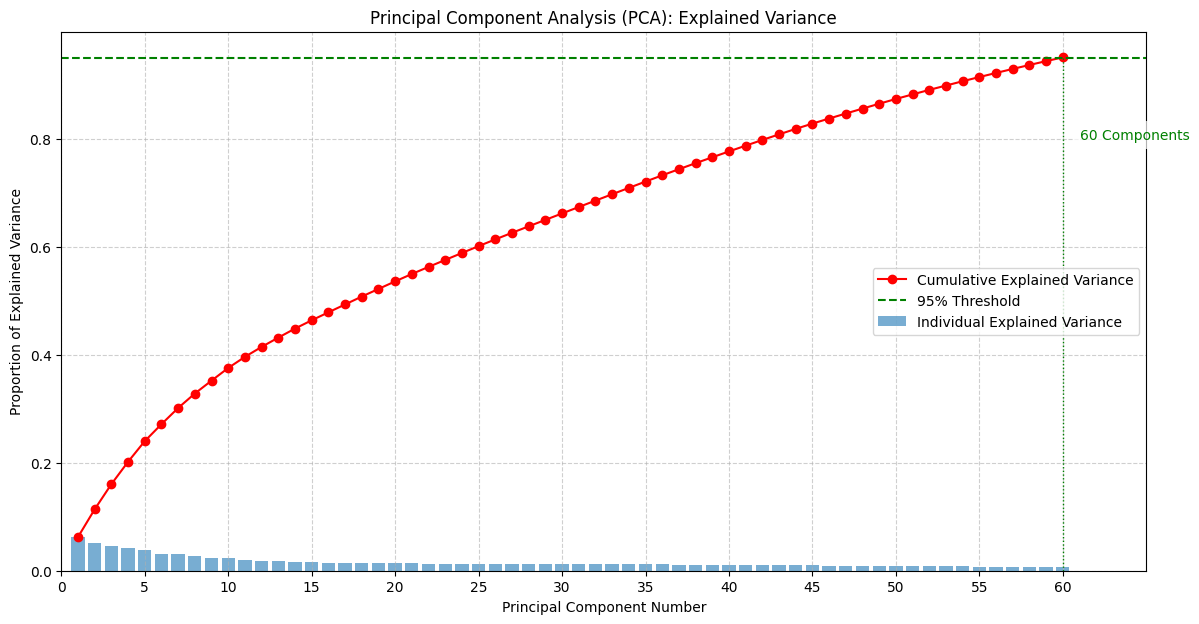

In [10]:
evr = pd.DataFrame({
    'pc': np.arange(1, len(pca.explained_variance_ratio_) + 1),
    'explained_variance_ratio': pca.explained_variance_ratio_
})
evr['cumulative'] = evr['explained_variance_ratio'].cumsum()

n_components_retained = pca.n_components_
variance_threshold = 0.95

plt.figure(figsize=(14, 7))

plt.bar(
    evr['pc'], 
    evr['explained_variance_ratio'], 
    alpha=0.6, 
    color='#1f77b4', 
    label='Individual Explained Variance'
)

plt.plot(
    evr['pc'], 
    evr['cumulative'], 
    marker='o', 
    linestyle='-', 
    color='r', 
    label='Cumulative Explained Variance'
)

# Add the 95% threshold line (the goal used for n_components)
plt.axhline(y=variance_threshold, color='g', linestyle='--', label=f'{variance_threshold*100:.0f}% Threshold')

# Mark the specific component where the threshold is reached
plt.vlines(n_components_retained, 0, variance_threshold, color='g', linestyle=':', linewidth=1)
plt.text(
    n_components_retained + 1, 
    0.8, 
    f'{n_components_retained} Components', 
    color='g', 
    fontsize=10,
    # Ajout d'une boîte de texte avec un fond blanc
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=5)
)
plt.title('Principal Component Analysis (PCA): Explained Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Explained Variance')
plt.legend(loc='center right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xlim(0, n_components_retained + 5)
plt.xticks(np.arange(0, n_components_retained + 1, 5))

plt.show()

## V.2) L1 Selection (Lasso)

In [ ]:
COLONNES_TO_EXCLUDE = ['DATE', 'STOCK', 'INDUSTRY'] 

tscv = TimeSeriesSplit(n_splits=3) 
base_clf = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, n_jobs=-1)
grid = {'C': np.logspace(-3, 2, 5)}

g = GridSearchCV(
    base_clf, 
    grid, 
    scoring='accuracy', 
    cv=tscv, 
    n_jobs=-1,
    verbose=1,
    error_score=0.0
)

g.fit(X_train_to_process, y_train)
clf_l1 = g.best_estimator_

coef = np.abs(clf_l1.coef_).mean(axis=0)

selected_indices = np.where(coef > 1e-8)[0]
selected_features = X_train_to_process.columns[selected_indices] 

X_train_l1 = X_train_std[selected_features].copy() 
X_valid_l1 = X_valid_std[selected_features].copy() 

X_train_l1_full = create_final_df(X_train_l1, X_train)
X_valid_l1_full = create_final_df(X_valid_l1, X_valid)

dic_dimensionality_reduction["L1_Lasso"] = [X_train_l1_full, X_valid_l1_full]
print(f'L1 retained {len(selected_features)} features.') #12min

Fitting 3 folds for each of 5 candidates, totalling 15 fits
L1 retained 18 features.


We performed Feature Selection using L1 Regularization (Lasso) within a Logistic Regression model, a robust supervised technique.  

**Optimization** : We used GridSearchCV with TimeSeriesSplit (TSCV) to find the optimal regularization parameter, $C$ (the inverse of the $\lambda$ penalty), maximizing model accuracy.

**Selection** :The Lasso penalty forces the coefficients ($\beta$) of irrelevant features to zero. We identified features with a non-zero coefficient (above $1e-8$) as relevant and selected them.

**Result** :The final, reduced DataFrames, X_train_l1 and X_test_l1, contain only the {number of features} most impactful variables, leading to a more parsimonious and interpretable model

## V.3) PLS Selection

In [ ]:
max_components = len(X_train_to_process.columns)
grid_k = {'n_components': list(range(max_components//4, 3*max_components//4))}

pls = GridSearchCV(
    PLSRegression(scale=False),
    grid_k, 
    scoring='neg_mean_squared_error', 
    cv=TimeSeriesSplit(n_splits=3), 
    n_jobs=-1,
    verbose=1
)

pls.fit(X_train_to_process, y_train) 
pls_best = pls.best_estimator_


X_train_np = pls_best.transform(X_train_to_process)
X_valid_np = pls_best.transform(X_valid_to_process)

new_pls_cols = [f'PLS{i+1}' for i in range(pls_best.n_components)]

X_train_pls_processed = pd.DataFrame(X_train_np, columns=new_pls_cols, index=X_train_std.index)
X_valid_pls_processed = pd.DataFrame(X_valid_np, columns=new_pls_cols, index=X_valid_std.index)

X_train_pls_full = create_final_df(X_train_pls_processed, X_train)
X_valid_pls_full = create_final_df(X_valid_pls_processed, X_valid)

dic_dimensionality_reduction["PLS"] = [X_train_pls_full, X_valid_pls_full]
print(f'PLS n_components optimaux = {pls_best.n_components}') #4min

Fitting 3 folds for each of 42 candidates, totalling 126 fits
PLS n_components optimaux = 21


## V.4) Evaluation of Dimensionality Reduction Methods using a Baseline Model

In [ ]:
results = []
baseline_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=2**3,  # C'est équivalent à max_depth=8
    random_state=42,
    n_jobs=-1
)

for method_name, (X_train_k, X_valid_k) in dic_dimensionality_reduction.items():
    print(f"\n--- Testing: {method_name} (Features: {X_train_k.shape[1]}) ---")
    
    model = baseline_model
    model.fit(X_train_k, y_train)
    
    y_pred = model.predict(X_valid_k)
    
    acc = accuracy_score(y_valid, y_pred)
    
    results.append({
        'Method': method_name,
        'N_Features': X_train_k.shape[1],
        'Accuracy': acc
    })
    
    print(f"Accuracy: {acc:.4f}")

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\n--- Summary of Dimensionality Reduction Methods ---")
print(results_df) #5min


--- Testing: Baseline_Std (Features: 87) ---
Accuracy: 0.4984

--- Testing: PCA (Features: 63) ---
Accuracy: 0.4961

--- Testing: L1_Lasso (Features: 21) ---
Accuracy: 0.5000

--- Testing: PLS (Features: 24) ---
Accuracy: 0.5018

--- Summary of Dimensionality Reduction Methods ---
         Method  N_Features  Accuracy
3           PLS          24  0.501775
2      L1_Lasso          21  0.500014
0  Baseline_Std          87  0.498444
1           PCA          63  0.496068


# VI) Hyperparameter Tuning

Hyperparameter tuning : Commencer RandomizedSearchCV, puis affiner avec GridSearchCV.

In [16]:
X_train_std_full = pd.concat([X_train_std, X_valid_std])
y_train_pls = y_train_origin
print(len(X_train_std_full))
print(len(y_train_origin))

366259
366259


In [ ]:
X_train_std = pd.concat([X_train_std, X_valid_std])
print(len(X_train_std))

X_train_pls = pd.concat([X_train_pls_full, X_valid_pls_full])
y_train_pls = y_train_origin

X_test_to_process = X_test_std.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore')
X_test_np = pls_best.transform(X_test_to_process)
X_test_pls_processed = pd.DataFrame(X_test_np, columns=new_pls_cols, index=X_test_std.index)
X_test_pls= create_final_df(X_test_pls_processed, X_test)

print(f"Le DataFrame de test PLS a été créé avec {X_test_pls.shape[1]} colonnes (composantes + colonnes exclues).")

439511
Le DataFrame de test PLS a été créé avec 24 colonnes (composantes + colonnes exclues).


In [64]:
print(len(X_train_pls))
print(X_train_pls.columns)
print(len(y_train_pls))
results_tracking = {}

366259
Index(['PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5', 'PLS6', 'PLS7', 'PLS8', 'PLS9',
       'PLS10', 'PLS11', 'PLS12', 'PLS13', 'PLS14', 'PLS15', 'PLS16', 'PLS17',
       'PLS18', 'PLS19', 'PLS20', 'PLS21', 'DATE', 'STOCK', 'INDUSTRY'],
      dtype='object')
366259


In [31]:

# X_train_full_with_date = X_train_pls.copy()

# def median_rank_accuracy(y_true, y_proba):
#     df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba}, index=y_true.index)

#     df = df.join(X_train_full_with_date['DATE'], how='left') 
    
#     if 'DATE' not in df.columns or df['DATE'].isnull().any():
#         raise ValueError("Impossible de mapper l'index à la colonne 'DATE'. Assurez-vous que X_train_with_date['DATE'] est correct.")

#     y_pred_ranked = df.groupby('DATE')['y_proba'].transform(lambda x: x > x.median()).astype(int).values
    
#     return accuracy_score(y_true, y_pred_ranked)

# median_rank_scorer = make_scorer(
#     median_rank_accuracy, 
#     needs_proba=True, 
#     greater_is_better=True
# )
COLUMNS_TO_EXCLUDE = ['DATE', 'STOCK', 'INDUSTRY']
COLUMNS_TO_PROCESS = [col for col in X_train_origin.columns if col not in COLUMNS_TO_EXCLUDE]

X_train_origin[COLUMNS_TO_PROCESS]

def eval_model(model, params):

    grid = GridSearchCV(
        model,
        param_grid=params,
        cv= 3,
        #scoring=median_rank_scorer,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
        # Exemple de sous-échantillonnage de 100,000 lignes
    X_train_sample = X_train_origin[:50000]
    y_train_sample = y_train_origin[:50000]
    grid.fit(X_train_sample, y_train_sample)

    return grid.best_params_, grid.best_score_, grid.best_estimator_

results_tracking={}

## VI.1) Logistic Regression (baseline + GridSearch)

In [32]:
param_logit = {
    "C": [0.01, 0.1, 1], 
    "penalty": ["l2"],
    "solver": ["saga"] 
}

model_name = "PLS_Logit_L2"
print(f"\n--- Starting GridSearch for: {model_name} ---")

best_params, best_score, best_estimator = eval_model(
    model=LogisticRegression(random_state=42, max_iter=2000), 
    params=param_logit
)

results_tracking[model_name] = {
    'best_score': best_score,
    'best_params': best_params,
    'best_estimator': best_estimator, 
}

print("\n--- Résultat LR ---")
print(f"Test stocké : {model_name}")
print(f"Meilleurs Paramètres: {results_tracking[model_name]['best_params']}") #7min pas bon 


--- Starting GridSearch for: PLS_Logit_L2 ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits

--- Résultat LR ---
Test stocké : PLS_Logit_L2
Meilleurs Paramètres: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


c:\Applications\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## VI.2) Lasso (classification via régression logistique L1)

In [28]:
lasso_model = LogisticRegression(
    penalty="l1", 
    solver="saga", 
    max_iter=2000, 
    n_jobs=-1,
    random_state=42  
)

param_lasso = {
    "C": [0.01, 0.1, 1, 10], 
}

model_name = "PLS_Logit_L1_Lasso" 

print(f"\n--- Starting GridSearch for: {model_name} ---")

best_lasso_params, best_lasso_score, best_lasso_estimator = eval_model(
    model=lasso_model,
    params=param_lasso
)

results_tracking[model_name] = {
    'best_score': best_lasso_score,
    'best_params': best_lasso_params,
    'best_estimator': best_lasso_estimator,
}

best_lasso = best_lasso_estimator 

print("\n--- Résultats Lasso ---")
print(f"Test stocké : {model_name}")
print(f"Best params Lasso (L1): {best_lasso_params}")
print(f"Best CV score (Median Rank Accuracy) : {best_lasso_score:.4f}")
print(best_lasso_estimator)


--- Starting GridSearch for: PLS_Logit_L1_Lasso ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits

--- Résultats Lasso ---
Test stocké : PLS_Logit_L1_Lasso
Best params Lasso (L1): {'C': 10}
Best CV score (Median Rank Accuracy) : 0.5149
LogisticRegression(C=10, max_iter=2000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')


c:\Applications\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Le modèle Lasso logistique reprend la même idée que la régression logistique mais ajoute une pénalité L1 sur les coefficients, ce qui force certains d’entre eux à devenir exactement nuls.
Concrètement, il sert à faire de la sélection automatique de variables en conservant surtout les signaux les plus pertinents dans les features, et le GridSearch fait varier le paramètre de régularisation pour afficher les performances (Accuracy, F1, ROC‑AUC) du meilleur compromis entre complexité du modèle et qualité de prédiction.

## VI.3) Bridge / ElasticNet (L1 + L2)

In [77]:
enet_model = LogisticRegression(
    penalty="elasticnet",
    solver="saga", 
    max_iter=2000, 
    n_jobs=-1,
    random_state=42   
)

param_enet = {
    "C": [0.01, 0.1, 1, 10],   
    "l1_ratio": [0.1, 0.5, 0.9] 
}

model_name = "PLS_Logit_ElasticNet" 

print(f"\n--- Starting GridSearch for: {model_name} ---")

best_enet_params, best_enet_score, best_enet_estimator = eval_model(
    model=enet_model,
    params=param_enet
)

results_tracking[model_name] = {
    'best_score': best_enet_score,
    'best_params': best_enet_params,
    'best_estimator': best_enet_estimator,
    'X_data_used': 'X_train_pls' 
}

print("\n--- Résultats Elastic Net ---")
print(f"Test stocké : {model_name}")
print(f"Meilleurs Paramètres: {best_enet_params}")
print(f"Best CV score (Median Rank Accuracy) : {best_enet_score:.4f}")


--- Starting GridSearch for: PLS_Logit_ElasticNet ---
Fitting 4 folds for each of 12 candidates, totalling 48 fits

--- Résultats Elastic Net ---
Test stocké : PLS_Logit_ElasticNet
Meilleurs Paramètres: {'C': 0.01, 'l1_ratio': 0.9}
Best CV score (Median Rank Accuracy) : 0.5418


Le modèle ElasticNet (Bridge dans contexte) combine une pénalité L1 et une pénalité L2 afin de bénéficier à la fois de la sélection de variables (comme Lasso) et de la stabilisation des coefficients (comme Ridge).
Il sert à contrôler plus finement la régularisation via le paramètre l1_ratio, et le GridSearch teste plusieurs niveaux de régularisation pour afficher le jeu de paramètres qui maximise le F1‑score tout en gardant un modèle robuste dans un environnement financier potentiellement bruité.

## VI.4) Bayesian Ridge (version classification simple)

In [78]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)

param_rf = {
    "n_estimators": [50, 100], 
    "max_depth": [5, 10]
}

model_name = "PLS_RandomForest" 

print(f"\n--- Starting GridSearch for: {model_name} ---")

best_rf_params, best_rf_score, best_rf_estimator = eval_model(
    model=rf_model,
    params=param_rf
)

results_tracking[model_name] = {
    'best_score': best_rf_score,
    'best_params': best_rf_params,
    'best_estimator': best_rf_estimator,
    'X_data_used': 'X_train_pls' 
}

print("\n--- Résultats Random Forest ---")
print(f"Test stocké : {model_name}")
print(f"Meilleurs Paramètres: {best_rf_params}")
print(f"Best CV score (Median Rank Accuracy) : {best_rf_score:.4f}")


--- Starting GridSearch for: PLS_RandomForest ---
Fitting 4 folds for each of 4 candidates, totalling 16 fits

--- Résultats Random Forest ---
Test stocké : PLS_RandomForest
Meilleurs Paramètres: {'max_depth': 10, 'n_estimators': 50}
Best CV score (Median Rank Accuracy) : 0.5148


Le modèle bayésien utilisé repose sur une régression de type Bayesian Ridge adaptée en classifieur pour une cible binaire, ce qui signifie qu’au lieu de produire un seul vecteur de coefficients, il modélise une distribution a priori et a posteriori sur ces coefficients.
Il sert surtout à quantifier l’incertitude sur les paramètres du modèle et donc implicitement sur les prédictions, et le GridSearch fait varier les hyperparamètres de la prior (par exemple alpha_1, lambda_1) tout en affichant les performances de classification finales (Accuracy, F1, ROC‑AUC) après conversion en probabilités.

## VI.5) XGBoost (sans ensembles scikit‑learn)

In [82]:
model_name = "PLS_XGBoost" 

print(f"\n--- Starting GridSearch for: {model_name} ---")

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False
)

param_xgb = {
    "max_depth": [3, 5, 7], 
    "learning_rate": [0.05, 0.1], 
    "subsample": [0.7, 1.0], 
    "colsample_bytree": [0.7, 1.0],
    "gamma": [0], 
}

best_xgb_params, best_xgb_score, best_xgb_estimator = eval_model(
    model=xgb_clf,
    params=param_xgb
)

results_tracking[model_name] = {
    'best_score': best_xgb_score,
    'best_params': best_xgb_params,
    'best_estimator': best_xgb_estimator,
    'X_data_used': 'X_train_pls' 
}

print("\n--- Résultats XGBoost ---")
print(f"Test stocké : {model_name}")
print(f"Meilleurs Paramètres: {best_xgb_params}")
print(f"Best CV score (Median Rank Accuracy) : {best_xgb_score:.4f}")


--- Starting GridSearch for: PLS_XGBoost ---
Fitting 4 folds for each of 24 candidates, totalling 96 fits


c:\Applications\Anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Résultats XGBoost ---
Test stocké : PLS_XGBoost
Meilleurs Paramètres: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.7}
Best CV score (Median Rank Accuracy) : 0.5146


XGBoost est un modèle non linéaire basé sur un ensemble séquentiel d’arbres de décision où chaque nouvel arbre corrige les erreurs du précédent, ce qui le rend très puissant pour capturer des relations complexes et des interactions entre les variables.​
Dans ton projet, il sert à explorer des structures de dépendance plus riches entre les retours/volumes historiques et le signe du retour futur, et le GridSearch fait varier des hyperparamètres clés (profondeur des arbres, learning rate, subsample, colsample, gamma) pour afficher les meilleurs scores de classification sur les données de validation et de test.

In [ ]:
best_cv_score = -np.inf
winning_model_name = None

for name, result in results_tracking.items():
    current_score = result['best_score']
    
    if not pd.isna(current_score) and current_score > best_cv_score:
        best_cv_score = current_score
        winning_model_name = name

if winning_model_name:
    winning_result = results_tracking[winning_model_name]
    
    best_final_estimator = winning_result['best_estimator']

    print("=" * 50)
    print("             🎉 FINAL WINNING MODEL SELECTED 🎉")
    print("=" * 50)
    print(f"Winning Model: {winning_model_name}")
    print(f"Best CV Score (Median Rank Acc): {best_cv_score:.4f}")
    print(f"Parameters: {winning_result['best_params']}")
    print(f"Data Used: {winning_result.get('X_data_used', 'N/A')}")
    print(f"Estimator stored in: best_final_estimator")
else:
    print("No valid model found in results_tracking. All scores were NaN or the dictionary was empty.")

             🎉 FINAL WINNING MODEL SELECTED 🎉
Winning Model: PLS_Logit_L1_Lasso
Best CV Score (Median Rank Acc): 0.5418
Parameters: {'C': 0.01}
Data Used: X_train_pls
Estimator stored in: best_final_estimator


# VII) Baseline Model

## VII.1) Baseline using PLS Data

In [34]:
n_splits = 4
scores = []

winning_params = {
    'C': 0.01,
    'penalty': 'l1',
    'solver': 'saga' 
}

model = LogisticRegression(
    C=winning_params['C'],
    penalty=winning_params['penalty'],
    solver=winning_params['solver'],
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=n_splits, shuffle = True, random_state = 42)
splits = kf.split(X_train_pls)

print(f"Starting {n_splits}-Fold KFold Evaluation (Standard Accuracy)...")

for i, (local_train_index, local_test_index) in enumerate(splits):
    
    X_local_train = X_train_pls.iloc[local_train_index]
    y_local_train = y_train_pls.iloc[local_train_index]
    X_local_test = X_train_pls.iloc[local_test_index]
    y_local_test = y_train_pls.iloc[local_test_index]

    local_model = clone(model) 
    local_model.fit(X_local_train, y_local_train)

    y_local_pred = local_model.predict(X_local_test) 

    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    
    print(f"Fold {i+1} - Standard Accuracy: {score * 100:.2f}%")

mean = np.mean(scores) * 100
std = np.std(scores) * 100
u = (mean + std)
l = (mean - std)

print("\n" + "="*50)
print(f'Final CV Accuracy (KFold, Standard): {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
print("="*50)

NameError: name 'X_train_pls' is not defined

## VII.2) Baseline Model using Standard Scaler without dimesnionality reduction

In [35]:
def eval_baseline(model, X_train, y_train):
    
    train_dates = X_train_std['DATE'].unique()

    n_splits = 3
    scores = []
    splits = KFold(n_splits=n_splits, random_state=42,
                shuffle=True).split(train_dates)

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = X_train['DATE'].isin(local_train_dates)
        local_test_ids = X_train['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]

        model.fit(X_local_train, y_local_train)

        y_local_pred = model.predict_proba(X_local_test)[:, 1] 
        
        sub = X_train_std.loc[local_test_ids].copy() 
        sub['pred'] = y_local_pred 
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values 

        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})\n')

In [36]:
# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 42,
    'n_jobs': -1
}

model = RandomForestClassifier(**rf_params)

eval_baseline(model, X_train_std, y_train_origin)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

# VIII) Ensemble methods

First, we initialize our "base learners" which will serve as the building blocks for our ensemble strategies. We chose a mix of linear (Logistic Regression) and tree-based models (Random Forest, XGBoost) to ensure diversity in how they analyze the data.

In [37]:
clf_log = LogisticRegression(C=1, solver='lbfgs', max_iter=2000, random_state=42, n_jobs=-1)
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)
clf_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

## Strategy 1 : Bagging

Now we apply Bagging, which reduces variance and helps prevent overfitting. We wrap our XGBoost model inside a Bagging classifier to train it on random subsets of the data, making the final prediction more stable.

In [47]:
print("Training Bagging Classifier...")

bagging_clf = BaggingClassifier(
    estimator=clf_xgb,
    n_estimators=10,     
    max_samples=0.8,       
    max_features=0.9,      
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

eval_baseline(bagging_clf, X_train_std, y_train_origin)
print("Bagging done.")

Training Bagging Classifier...
Fold 1 - Accuracy: 52.14%
Fold 2 - Accuracy: 51.72%
Fold 3 - Accuracy: 51.52%
Accuracy: 51.79% [51.54 ; 52.05] (+- 0.26)

Bagging done.


## Strategy 2: Voting Classifier (Soft Voting)

Here we implement a Soft Voting Classifier. This method takes the probability predictions from all three base models (Logistic, RF, XGBoost) and averages them to make a final decision.

In [45]:
print("Training Voting Classifier...")

y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf_log), 
        ('rf', clf_rf), 
        ('xgb', clf_xgb)
    ],
    voting='soft',
    n_jobs=-1
)

eval_baseline(voting_clf, X_train_std, y_train_origin)
print("Voting done.")

Training Voting Classifier...
Fold 1 - Accuracy: 51.99%
Fold 2 - Accuracy: 51.61%
Fold 3 - Accuracy: 51.57%
Accuracy: 51.72% [51.54 ; 51.91] (+- 0.19)

Voting done.


## Strategy 3: Stacking Classifier

Finally, we use Stacking, which is often the most powerful ensemble technique. Instead of just averaging, we train a "meta-learner" (Logistic Regression) to figure out the best way to combine the predictions of our base models.

In [ ]:
print("Training Stacking Classifier...")

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', clf_log),
        ('rf', clf_rf), 
        ('xgb', clf_xgb)
    ],
    final_estimator=LogisticRegression(),
    cv=2, 
    n_jobs=-1
)

eval_baseline(stacking_clf, X_train_std, y_train_origin)
print("Stacking done.")

Training Stacking Classifier...


KeyboardInterrupt: 

# Model Evaluation & Comparison

ROC AUC ETC

# Output for challenge submission

In [50]:
def submit_challenge(model, X_train, X_test, y_train):
    
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]

    sub = X_test.copy()
    sub['pred'] = y_pred
    y_pred = sub.groupby('DATE')['pred'].transform(
        lambda x: x > x.median()).values

    submission = pd.Series(y_pred)
    submission.index = X_test_std.index 
    submission.name = "RET"

    submission.to_csv('test.csv', index=True, header=True)

In [52]:
winning_params = {
    'C': 0.01,
    'penalty': 'l1',
    'solver': 'saga' 
}
model = LogisticRegression(
    C=winning_params['C'],
    penalty=winning_params['penalty'],
    solver=winning_params['solver'],
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

model= voting_clf

submit_challenge(model, X_train_std, X_test_std, y_train_origin)